# Jupyter Notebook for Data Visualization of HTS 2025 Paper Datasets
## Author: Anish Vasan
## Date: 2025/08/08

## Notebook Setup

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

In [2]:
plt.style.use(['science', 'nature'])
plot_params = {
    "figure.dpi": "200",
    "axes.labelsize": 14,
    "axes.linewidth": 1.5,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.title_fontsize": 16,
    "legend.fontsize": 16,
    "xtick.major.size": 3.5,
    "xtick.major.width": 1.5,
    "xtick.minor.size": 2.5,
    "xtick.minor.width": 1.5,
    "ytick.major.size": 3.5,
    "ytick.major.width": 1.5,
    "ytick.minor.size": 2.5,
    "ytick.minor.width": 1.5,
}
plt.rcParams.update(plot_params)

sns.set_style("ticks")

#matplotlib inline

### Functions

#### Data Preparation Functions

In [3]:
def process_excel_files(file_name_fn, file_path_fn)->dict:
    """Process a list of Excel files generate DataFrames."""
    print(f"Processing file: {file_path_fn}")
    data = pd.read_excel(file_path_fn, sheet_name=None)

    # Load required sheets, dropping unnecessary columns
    condition_map = data['condition_map']
    is_broken = data['is_broken'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    is_closed = data['is_closed'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_area = data['wound_area'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_minor_axis_length = data['wound_minor_axis_length'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    wound_major_axis_length = data['wound_major_axis_length'].drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    # import multi-index df for pillars
    relative_pillar_distances = pd.read_excel(file_path_fn, sheet_name='relative_pillar_distances', header=1)
    relative_pillar_distances = relative_pillar_distances.drop(columns=['Time', 'Unnamed: 0', 'Frame'])
    relative_pillar_distances = relative_pillar_distances.stack().str.split(' ', expand=True).unstack()
    relative_pillar_distances = relative_pillar_distances.dropna(axis=1, how='all')
    relative_pillar_distances = relative_pillar_distances.astype(float)

    # Extract time index
    time_index = data['wound_area']['Time']

    # Filter wound area data based on is_broken and is_closed
    wound_area_filtered, columns_to_drop = filter_wound_area(wound_area, is_broken, is_closed)

    # Drop the columns in wound_minor_axis_length, major_axis_length, and relative_pillar_distances (second level header) that were dropped from wound_area_filtered
    if not columns_to_drop:
        print("No columns were dropped during filtering.")
    else:
        print(f"Dropping columns from other parameters")
    wound_minor_axis_length = wound_minor_axis_length.drop(columns=columns_to_drop)
    wound_major_axis_length = wound_major_axis_length.drop(columns=columns_to_drop)
    #relative_pillar_distances = relative_pillar_distances.drop(columns=columns_to_drop, level=1)

    # Identify outliers based on major and minor axis lengths at time 0
    outlier_wells, bounds = identify_outliers(
        wound_minor_axis_length.iloc[0], wound_major_axis_length.iloc[0],wound_area_filtered.iloc[0]
    )
    print(f"Wells outside bounds for {file_name_fn}: \n{[key for key in outlier_wells.keys()]}")
    # Plot wound axis lengths
    plot_wound_axis_lengths(
        wound_major_axis_length.iloc[0],
        wound_minor_axis_length.iloc[0],
        bounds, outlier_wells, file_name_fn
    )
    plot_wound_area(wound_area_filtered.iloc[0],bounds, outlier_wells, file_name_fn)
    # Create condition dictionary
    dict_conditions = create_dict_condition(condition_map, wound_area_filtered)

    # Normalize wound area data
    wound_area_normalized = normalize_wound_area(wound_area_filtered)

    # Return processed data
    return {
        'dict_condition': dict_conditions,
        'wound_area_filtered': wound_area_filtered,
        'wound_area_normalized': wound_area_normalized,
        'wound_minor_axis_length': wound_minor_axis_length,
        'wound_major_axis_length': wound_major_axis_length,
        'outlier_wells': outlier_wells,
        'time_index': time_index,
        'relative_pillar_distances': relative_pillar_distances
    }

def filter_wound_area(wound_area_input, is_broken_input, is_closed_input)->tuple:
    """Filter the wound_area DataFrame based on is_broken and is_closed."""

    # Drop columns where is_broken=1 before is_closed=1 or if the first is_broken=1
    columns_to_drop = []
    for col in is_broken_input.columns:
        if col in wound_area_input.columns:

            # Check if the first value of is_broken is 1
            if is_broken_input[col].iloc[0] == 1:
                if col not in columns_to_drop:
                    columns_to_drop.append(col)

            # Find first index where is_broken is 1
            broken_indices = is_broken_input[col][is_broken_input[col] == 1].index
            # Find first index where is_closed is 1
            closed_indices = is_closed_input[col][is_closed_input[col] == 1].index

            if not broken_indices.empty:
                first_broken = broken_indices[0]
                if closed_indices.empty or first_broken < closed_indices[0]:
                    columns_to_drop.append(col)

    # Print the columns that will be dropped
    print("Columns dropped due to is_broken condition:", columns_to_drop)
    # Drop the columns from wound_area
    wound_area_filtered_fn = wound_area_input.drop(columns=columns_to_drop)
    columns_to_drop_output = columns_to_drop.copy()  # Store the columns to drop for later use

    # Now filter based on is_closed=1
    # Reset the wound_area_filtered_fn to the current filtered state
    columns_to_drop = []
    # Set values to 0 where is_closed is 1
    for col in is_closed_input.columns:
        if col in wound_area_filtered_fn.columns:
            wound_area_filtered_fn[col] = np.where(is_closed_input[col] == 1, 0, wound_area_filtered_fn[col])
            # Append the column to columns_to_drop if the first value is 0 (this assumes that if the first value is 0, the tissue was not injured and no injury was segmented)
            if wound_area_filtered_fn[col].iloc[0] == 0:
                columns_to_drop.append(col)

    # Print the columns that will be dropped due to is_closed and is_broken conditions
    print("Columns dropped due to is_closed[0]=0 condition:", columns_to_drop)
    # Drop the columns from wound_area
    wound_area_filtered_output = wound_area_filtered_fn.drop(columns=columns_to_drop)
    print('Dropped')
    columns_to_drop_output.extend(columns_to_drop)
    print(columns_to_drop_output)
    return wound_area_filtered_output, columns_to_drop_output

def create_dict_condition(condition_map_input, wound_area_filtered_input)->dict:
    """Create a dictionary of conditions and their corresponding wells."""
    dict_condition_fn = {}
    for index, row in condition_map_input.iterrows():
        condition_name = row['Condition_Name']
        well_name_fn = row['Well']

        # Check if the well name exists in wound_area_filtered columns
        waf_column_split = [col.split('_')[1] for col in wound_area_filtered_input.columns]
        if well_name_fn in waf_column_split:
            # Get the full column name that contains the well name
            full_well_name = [col for col in wound_area_filtered_input.columns if col.split('_')[1] == well_name_fn][0]
            if condition_name not in dict_condition_fn:
                dict_condition_fn[condition_name] = []
            dict_condition_fn[condition_name].append(full_well_name)
    return dict_condition_fn

def combine_conditions(extracted_data_input)->tuple:
    """Combine conditions from processed data into a single dictionary with DataFrames."""
    dict_combined_condition_fn = {}
    dict_counter = {}
    for file_name, data_fn in extracted_data_input.items():
        condition_dict_fn = data_fn['dict_condition']
        wound_area_normalized_fn = data_fn['wound_area_normalized']
        relative_pillar_distance_fn = data_fn['relative_pillar_distances']

        for condition_fn, wells in condition_dict_fn.items():
            if condition_fn not in dict_combined_condition_fn:
                # Initialize with the first file's data for this condition
                dict_combined_condition_fn[condition_fn]={}
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = wound_area_normalized_fn[wells].copy()
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'] = relative_pillar_distance_fn.loc[:, (slice(None), wells)].copy()
                #Rename the columns to include the file name
                new_well_names_fn = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'].columns = new_well_names_fn
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns = dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns.set_levels([f"{file_name}-{label}" for label in dict_combined_condition_fn[condition_fn]['relative_pillar_distances'].columns.levels[1]], level=1)

                # Initialize the dictionary for the new condition in dict_counter
                dict_counter[condition_fn] = {}
                dict_counter[condition_fn]["wells"] = len(wells)
                dict_counter[condition_fn]["experiments"] = 1
            else:
                # Concatenate wells from additional files
                new_data_wa = wound_area_normalized_fn[wells]
                new_data_rpd = relative_pillar_distance_fn.loc[:, (slice(None), wells)]
                new_data_wa.columns = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = pd.concat([dict_combined_condition_fn[condition_fn]['wound_area_normalized'], new_data_wa], axis=1)
                dict_combined_condition_fn[condition_fn]['relative_pillar_distances'] = pd.concat([dict_combined_condition_fn[condition_fn]['relative_pillar_distances'], new_data_rpd], axis=1)
                dict_counter[condition_fn]["wells"] = dict_counter[condition_fn]["wells"] + len(wells)
                dict_counter[condition_fn]["experiments"] = dict_counter[condition_fn]["experiments"] + 1

    pd_counter_output = pd.DataFrame.from_dict(dict_counter, orient='index')

    return dict_combined_condition_fn, pd_counter_output

def reshape_combined_conditions(extracted_data_input, time_index_input, cell_type_df)->pd.DataFrame:
    """Convert combined condition dictionary to long format DataFrame for seaborn"""
    # Create a mapping from experiment name to cell type
    cell_type_map = pd.Series(
        cell_type_df['cell_type'].values,
        index=cell_type_df['filename']
    ).to_dict()

    # Create a mapping from experiment name to passage number
    passage_map = pd.Series(
        cell_type_df['passage'].values,
        index=cell_type_df['filename']
    ).to_dict()

    # Create a list to hold all the data
    all_data = []
    # Iterate through each condition and its DataFrame
    for experiment_fn, data_fn in extracted_data_input.items():
        wan = data_fn['wound_area_normalized'][:len(time_index_input)].copy()
        wan.index = time_index_input
        waf = data_fn['wound_area_filtered'][:len(time_index_input)].copy()
        waf.index = time_index_input
        combined_wound_areas = pd.concat([wan, waf],
                                         axis=1,
                                         keys=['wound_area_normalized', 'wound_area_pixels'])
        long_wound_areas = combined_wound_areas.stack(level=1,future_stack=True).reset_index()
        long_wound_areas.rename(columns={'level_1': 'well'}, inplace=True)

        rpd_wide = data_fn['relative_pillar_distances'].iloc[:len(time_index_input)].copy()
        rpd_wide.index = time_index_input
        rpd_wide.columns.names = ['rpd_id', 'well']
        rpd_wide.columns = rpd_wide.columns.set_levels([f'rpd_{i}' for i in rpd_wide.columns.get_level_values('rpd_id').unique()], level='rpd_id')
        rpd_long = rpd_wide.stack(level=['well'], future_stack=True).reset_index()

        merged_df = pd.merge(long_wound_areas, rpd_long, on=['Time', 'well'], how='left')
        merged_df['exp'] = experiment_fn
        # Use the map to get the cell type, with a default value for safety
        merged_df['cell_type'] = cell_type_map.get(experiment_fn, 'Unknown')
        merged_df['passage'] = passage_map.get(experiment_fn, 'Unknown')
        condition_lookup = {
            well_fn: cond for cond, wells_fn in data_fn['dict_condition'].items() for well_fn in wells_fn
        }
        merged_df['condition_map'] = merged_df['well'].map(condition_lookup)
        merged_df['well'] =  [experiment_fn + '_' + well_fn for well_fn in merged_df['well']]
        all_data.append(merged_df)
    all_data = pd.concat(all_data, ignore_index=True).rename(columns={'Time': 'time_index'})
    return all_data

def drop_outliers(extracted_data_input):
    # Drop all outlier wells from the wound_area_normalized DataFrame
    for file_name_fn, data_fn in extracted_data_input.items():
        outlier_wells_fn = data_fn['outlier_wells']
        wound_area_normalized_fn = data_fn['wound_area_normalized']
        if outlier_wells_fn:
            print(f"Dropping outlier wells for {file_name_fn}: {list(outlier_wells_fn.keys())}")
            # Create a list of columns to drop
            columns_to_drop_fn = [col for col in wound_area_normalized_fn.columns if any(well in col for well in outlier_wells_fn.keys())]
            # Drop the columns from the DataFrame
            data_types = ['wound_area_normalized', 'wound_area_filtered', 'wound_minor_axis_length', 'wound_major_axis_length', 'relative_pillar_distances']
            for data_type in data_types:
                for col in columns_to_drop_fn:
                    if col in data_fn[data_type].columns:
                        data_fn[data_type].drop(columns=col, inplace=True)
                extracted_data_input[file_name_fn][data_type]= data_fn[data_type]

            # Drop the outlier wells from the dict_condition
            dict_condition_fn = data_fn['dict_condition']
            for condition_fn, wells_fn in dict_condition_fn.items():
                dict_condition_fn[condition_fn] = [well for well in wells_fn if well not in columns_to_drop_fn]
            extracted_data_input[file_name_fn]['dict_condition'] = dict_condition_fn


    return extracted_data_input

#### Data Calculation Functions

In [4]:
def identify_outliers(wound_minor_axis_length_input, wound_major_axis_length_input, wa_in)->tuple:
    """Identify outlier wells based on minor and major axis lengths."""
    # Calculate bounds for major and minor axis lengths
    minor_lower_bound, minor_upper_bound = calculate_bounds(wound_minor_axis_length_input)
    major_lower_bound, major_upper_bound = calculate_bounds(wound_major_axis_length_input)
    wa_lower_bound, wa_upper_bound = calculate_bounds(wa_in)
    outlier_wells_output = {}
    for i, (major, minor,wa) in enumerate(zip(wound_major_axis_length_input, wound_minor_axis_length_input,wa_in)):
        if major < major_lower_bound or major > major_upper_bound or minor < minor_lower_bound or minor > minor_upper_bound or wa < wa_lower_bound or wa > wa_upper_bound:
            outlier_wells_output[wound_major_axis_length_input.index[i]]= (major, minor, wa)
    return outlier_wells_output, (minor_lower_bound, minor_upper_bound, major_lower_bound, major_upper_bound, wa_lower_bound, wa_upper_bound)

def calculate_bounds(parameter_input)->tuple:
    """Calculate lower and upper bounds for outlier detection."""
    average = parameter_input.mean()
    iqr = parameter_input.quantile(0.75) - parameter_input.quantile(0.25)
    lower_bound = average - 1.5 * iqr
    upper_bound = average + 1.5 * iqr
    return lower_bound, upper_bound

def normalize_wound_area(wound_area_filtered_input)->pd.DataFrame:
    """Normalize the wound area data to the initial value at time 0."""
    wound_area_normalized_fn = wound_area_filtered_input.copy()
    for col in wound_area_normalized_fn.columns:
        initial_value = wound_area_normalized_fn[col].iloc[0]
        if initial_value != 0:  # Avoid division by zero
            wound_area_normalized_fn[col] = wound_area_normalized_fn[col] / initial_value
        else:
            wound_area_normalized_fn[col] = np.nan  # Set to NaN if initial value is zero
    return wound_area_normalized_fn

#### Data Plotting Functions

In [5]:
def plot_wound_axis_lengths(wound_major_axis_length_input, wound_minor_axis_length_input, bounds_input, outlier_wells_input, file_name_input)->None:
    """Plot the wound major vs minor axis lengths at time 0."""

    # Extract the bounds for minor and major axis lengths
    minor_lower_bound, minor_upper_bound, major_lower_bound, major_upper_bound,wa_up,wa_lower = bounds_input

    # Create DataFrame for seaborn
    scatter_data = pd.DataFrame({
        'major_axis': wound_major_axis_length_input,
        'minor_axis': wound_minor_axis_length_input,
        'well': wound_major_axis_length_input.index,
        'is_outlier': [well in outlier_wells_input for well in wound_major_axis_length_input.index]
    })

    plt.figure(figsize=(10, 6))

    # Create the scatter plot
    ax = sns.scatterplot(
        data=scatter_data,
        x='major_axis',
        y='minor_axis',
        hue='is_outlier',
        palette={True: 'red', False: 'blue'},
        alpha=1,
        s=50
    )



    ax.axhline(minor_lower_bound, color='red', linestyle='--', label='Min Minor Axis Length')
    ax.axhline(minor_upper_bound, color='green', linestyle='--', label='Max Minor Axis Length')
    ax.axvline(major_lower_bound, color='red', linestyle='--', label='Min Major Axis Length')
    ax.axvline(major_upper_bound, color='green', linestyle='--', label='Max Major Axis Length')

    # Plot scatter plot of the axis lengths at first time point
    ax.set_title('Wound Major vs Minor Axis Length at Time 0')
    ax.set(
        xlabel='Wound Major Axis Length',
        ylabel='Wound Minor Axis Length'
    )
    # Label the wells that are outside the bounds
    for well in outlier_wells_input:
        major, minor, wa = outlier_wells_input[well]
        plt.annotate(f'{well}', (major, minor), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    plt.legend( loc='upper right', title='Outlier Wells', fontsize='small', title_fontsize='medium', frameon=True, fancybox=True)
    plt.savefig(f'wound_axis_lengths_{file_name_input}.svg', format='svg')
    plt.show()

def plot_wound_area(wound_area_input, bounds_input, outlier_wells_input, file_name_input)->None:
    """Plot the wound major vs minor axis lengths at time 0."""

    # Extract the bounds for minor and major axis lengths
    minor_lower_bound, minor_upper_bound, major_lower_bound, major_upper_bound, wa_upper, wa_lower = bounds_input

    # Create DataFrame for seaborn
    scatter_data = pd.DataFrame({
        'wound_area': wound_area_input,
        'well': wound_area_input.index,
        'is_outlier': [well in outlier_wells_input for well in wound_area_input.index]
    })
    # Add numerical index column
    scatter_data['well_index'] = range(len(scatter_data))
    plt.figure(figsize=(10, 6))

    # Create the scatter plot
    ax = sns.scatterplot(
        data=scatter_data,
        x='well_index',
        y='wound_area',
        hue='is_outlier',
        palette={True: 'red', False: 'blue'},
        alpha=1,
        s=50
    )

    # Label the wells that are outside the bounds
    for well in outlier_wells_input:
        major, minor, wa = outlier_wells_input[well]
        well_idx = scatter_data.loc[scatter_data['well'] == well, 'well_index'].iloc[0]
        plt.annotate(f'{well}', (well_idx, wa), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    ax.axhline(wa_lower, color='red', linestyle='--', label='Min wa')
    ax.axhline(wa_upper, color='green', linestyle='--', label='Max wa')

    # Plot scatter plot of the axis lengths at first time point
    ax.set_title('Wound Area at T=0')
    ax.set(
        xlabel='well',
        ylabel='Wound Area'
    )
    # Label the wells that are outside the bounds
    # for well in outlier_wells_input:
    #     major, minor, wa = outlier_wells_input[well]
    #     plt.annotate(f'{well}', (major, minor), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    plt.legend( loc='upper right', title='Outlier Wells', fontsize='small', title_fontsize='medium', frameon=True, fancybox=True)
    plt.savefig(f'wound_axis_lengths_{file_name_input}.svg', format='svg')
    plt.show()


## Notebook Operation

### Load Data and Filter for Outliers
#### User Input Required Here:
- Specify the directory and file names
- Define the control group name to compare against
- Pick outlier wells to drop manually if needed


In [6]:
# Define the list of Excel files to process
##** User Input Required **##
dir_parent = 'Z:\\Anish\\Code Analyzed Data\\20250706'
file_names = [
    #'EMW6.xlsx',
    #'R7P15_AI.xlsx',
    #'R7P21_AI.xlsx',
    # 'R7P22_AI.xlsx',
    # 'EMW13.xlsx',
    #'20220329_RAPA_AI.xlsx',
    #'R2P12_AI.xlsx',
    #'R7P1_AI_forcode.xlsx',
    #'R7P2_AI_forcode.xlsx',
    #'R7P6_AI.xlsx',
    #'R7P5_AI.xlsx',
    #'R7P8_AI.xlsx',
    #'R7P9_AI.xlsx',
    #'R7P10_AI.xlsx',
    #'R7P11_AI.xlsx',
    #'R7P13_AI.xlsx',
]

# You can add more file names to the list as needed.
# If you want to process all files in the directory, you can uncomment the following lines:
#file_names2 = [f for f in os.listdir(dir_parent) if f.endswith('.xlsx')]

# Define the name of the Control Group to compare against
control_group_name = 'DMSO'

Filenames to process: ['R7P11_AI.xlsx', 'R7P13_AI.xlsx']
Processing R7P11_AI.xlsx...
Processing file: Z:\Anish\Code Analyzed Data\20250706\R7P11_AI.xlsx
Columns dropped due to is_broken condition: ['s006_A09', 's008_B09', 's008_B09', 's023_C11', 's023_C11', 's025_D12', 's031_E01', 's035_E05', 's037_E07', 's050_G02', 's050_G02', 's055_G11', 's058_H06']
Columns dropped due to is_closed[0]=0 condition: ['s003_A03']
Dropped
['s006_A09', 's008_B09', 's008_B09', 's023_C11', 's023_C11', 's025_D12', 's031_E01', 's035_E05', 's037_E07', 's050_G02', 's050_G02', 's055_G11', 's058_H06', 's003_A03']
Dropping columns from other parameters
Wells outside bounds for R7P11_AI: 
['s007_B12', 's056_G12']


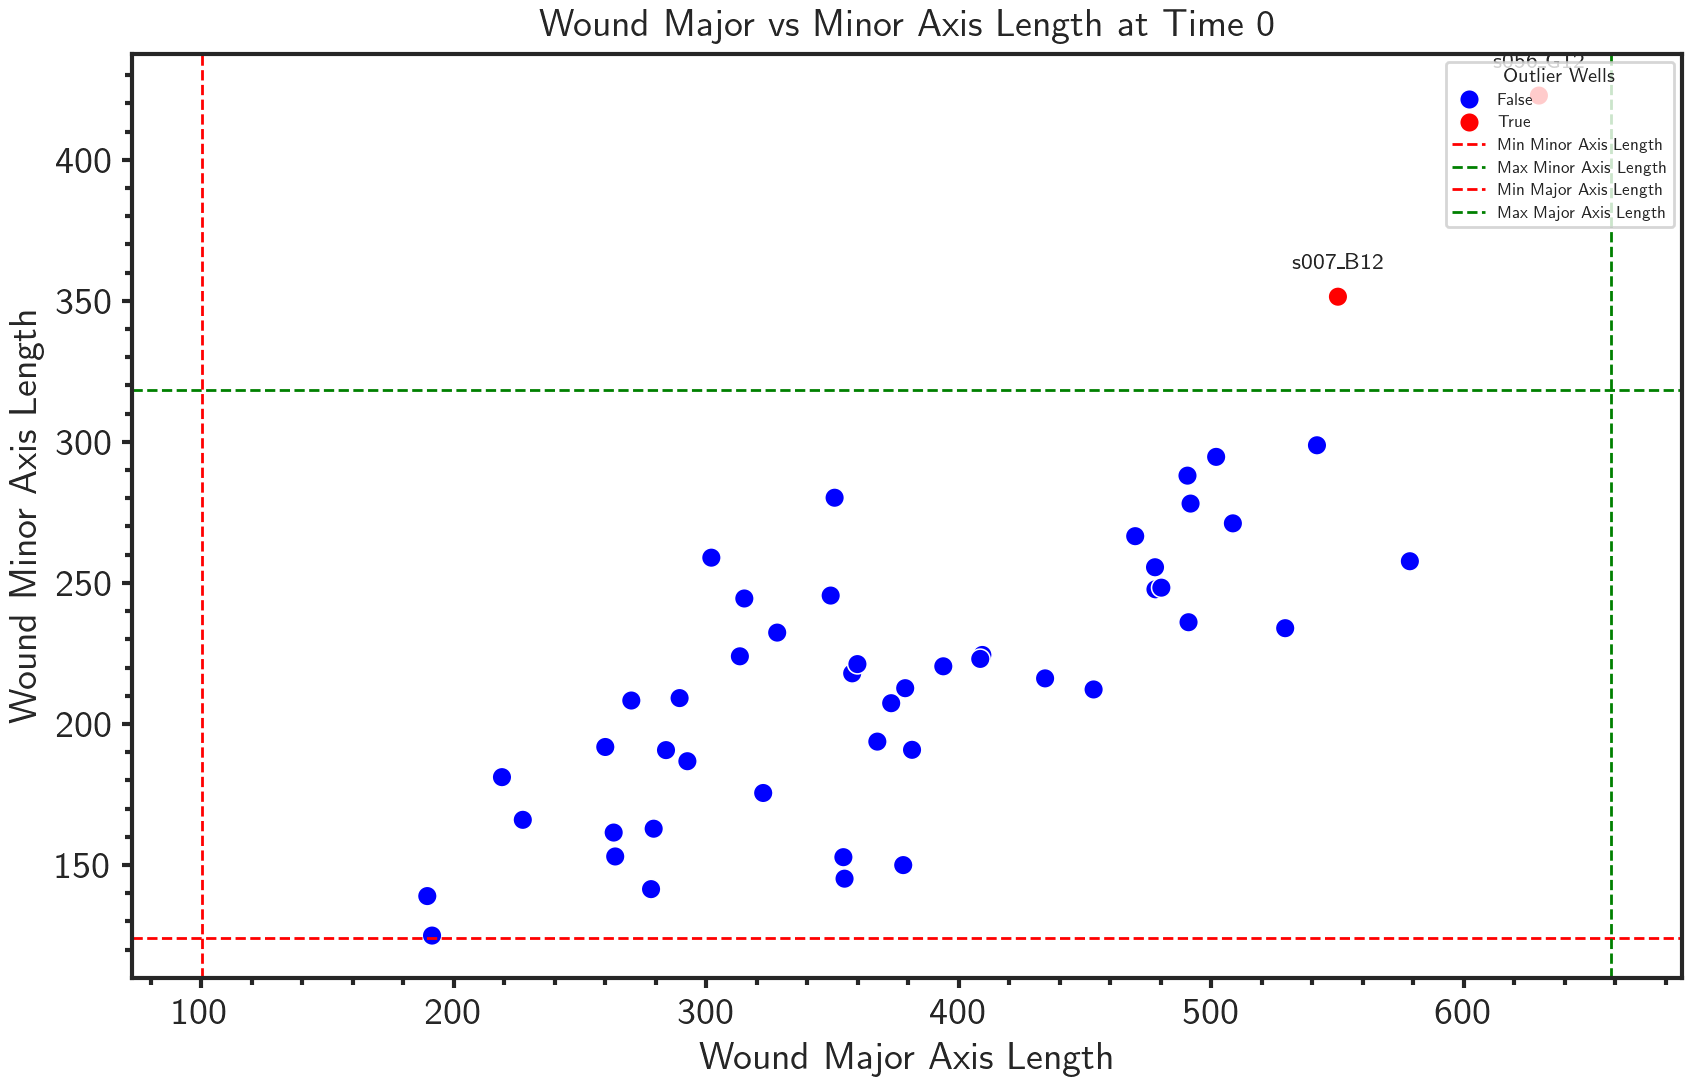

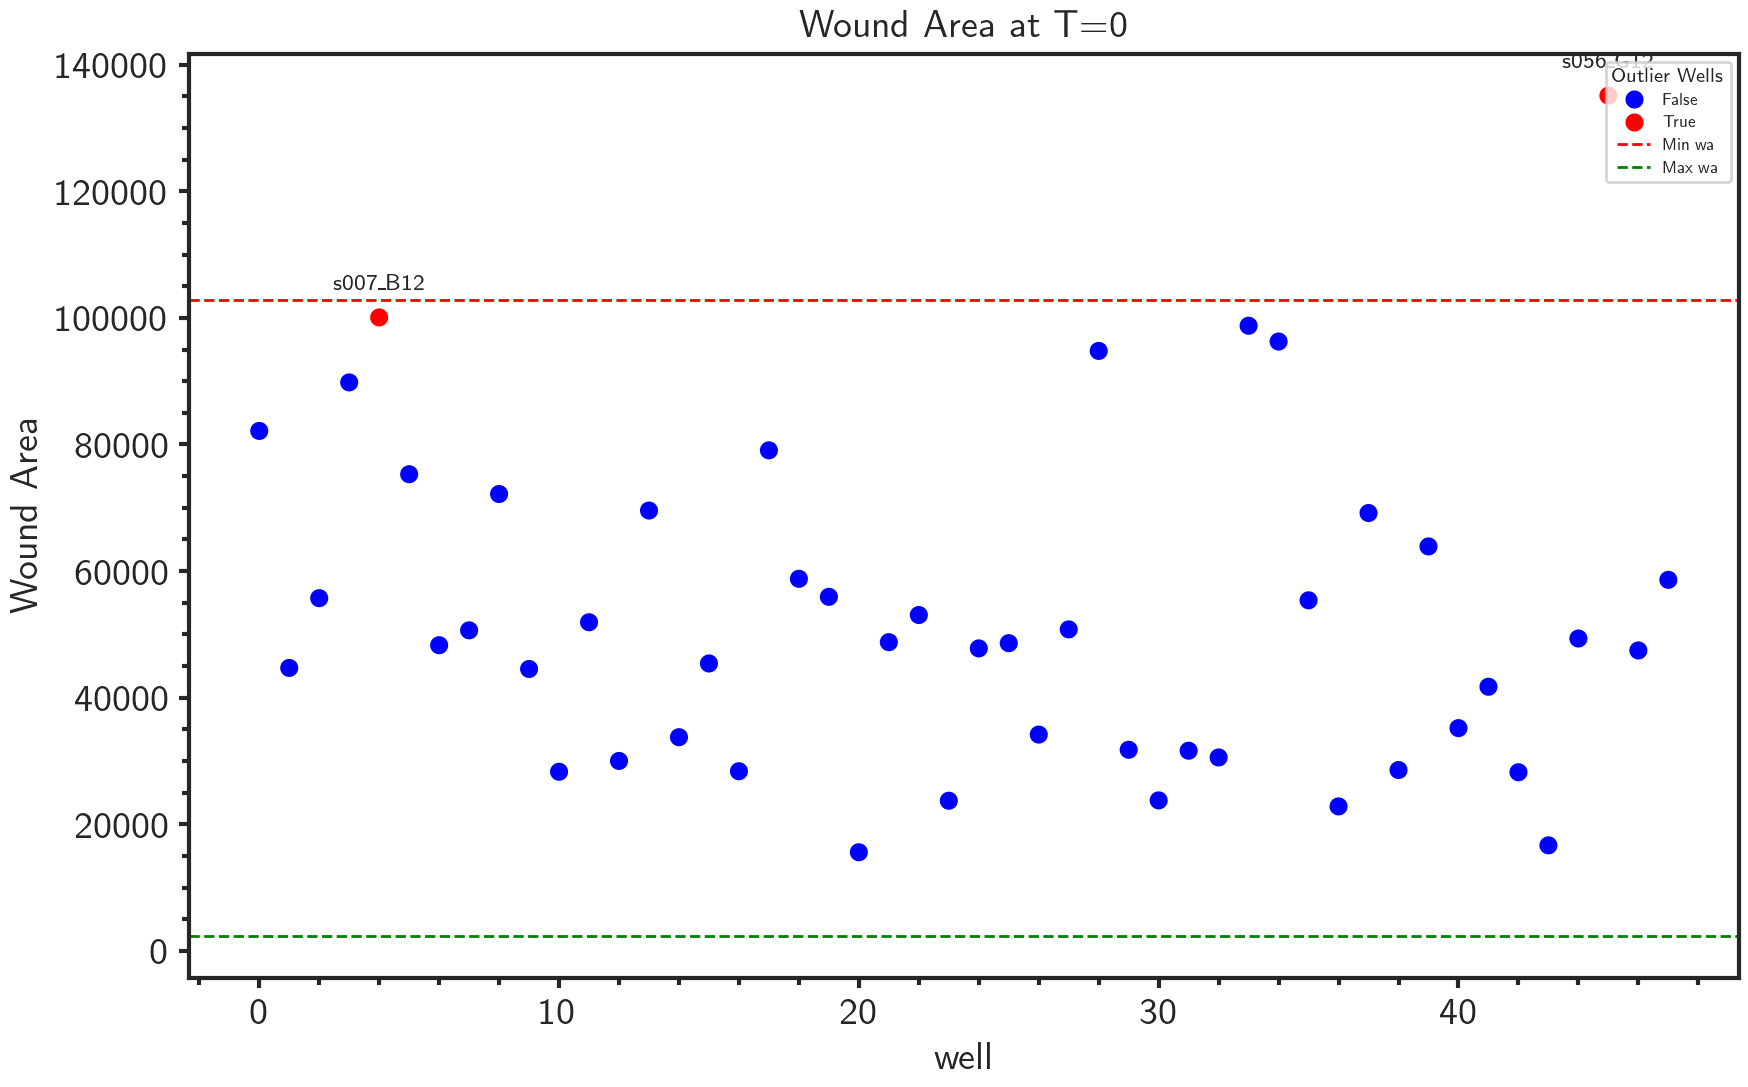

Finished processing R7P11_AI.xlsx.
Processing R7P13_AI.xlsx...
Processing file: Z:\Anish\Code Analyzed Data\20250706\R7P13_AI.xlsx
Columns dropped due to is_broken condition: ['s006_B11', 's006_B11', 's021_D12', 's021_D12', 's038_E11', 's038_E11', 's050_F02', 's054_G03', 's054_G03', 's068_H02']
Columns dropped due to is_closed[0]=0 condition: []
Dropped
['s006_B11', 's006_B11', 's021_D12', 's021_D12', 's038_E11', 's038_E11', 's050_F02', 's054_G03', 's054_G03', 's068_H02']
Dropping columns from other parameters
Wells outside bounds for R7P13_AI: 
['s007_B07', 's012_B02', 's034_E05', 's053_G02']


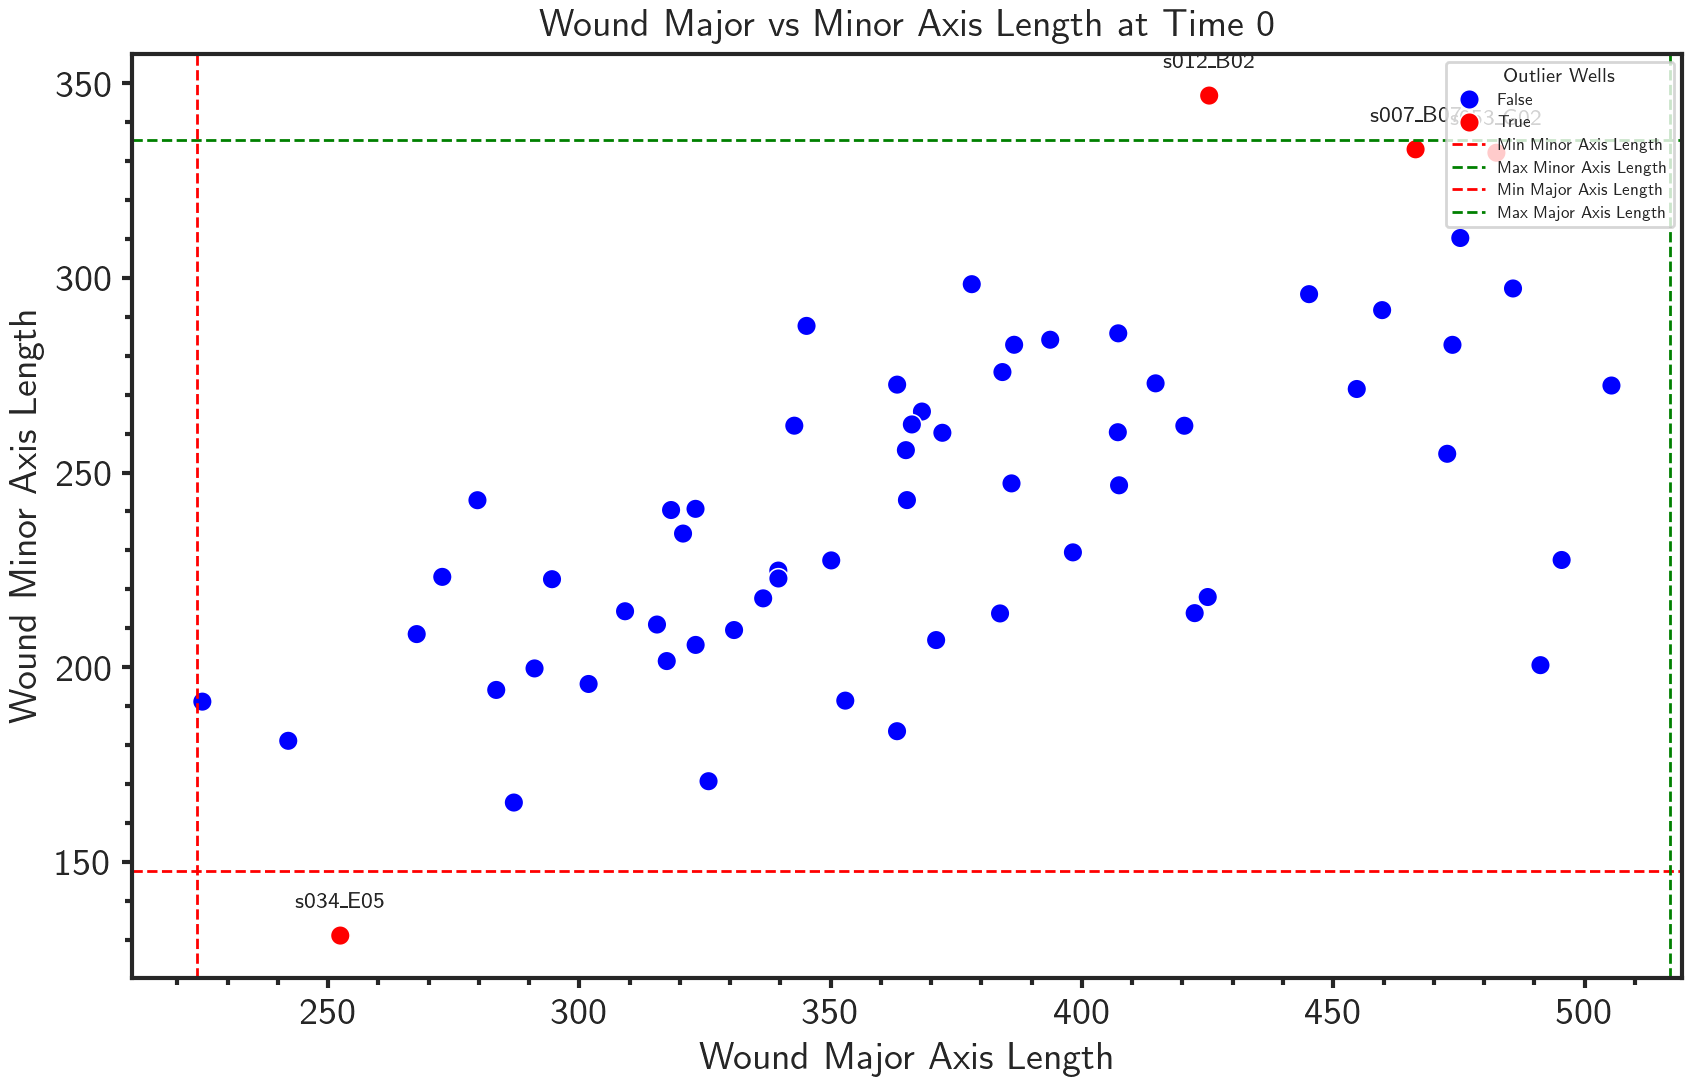

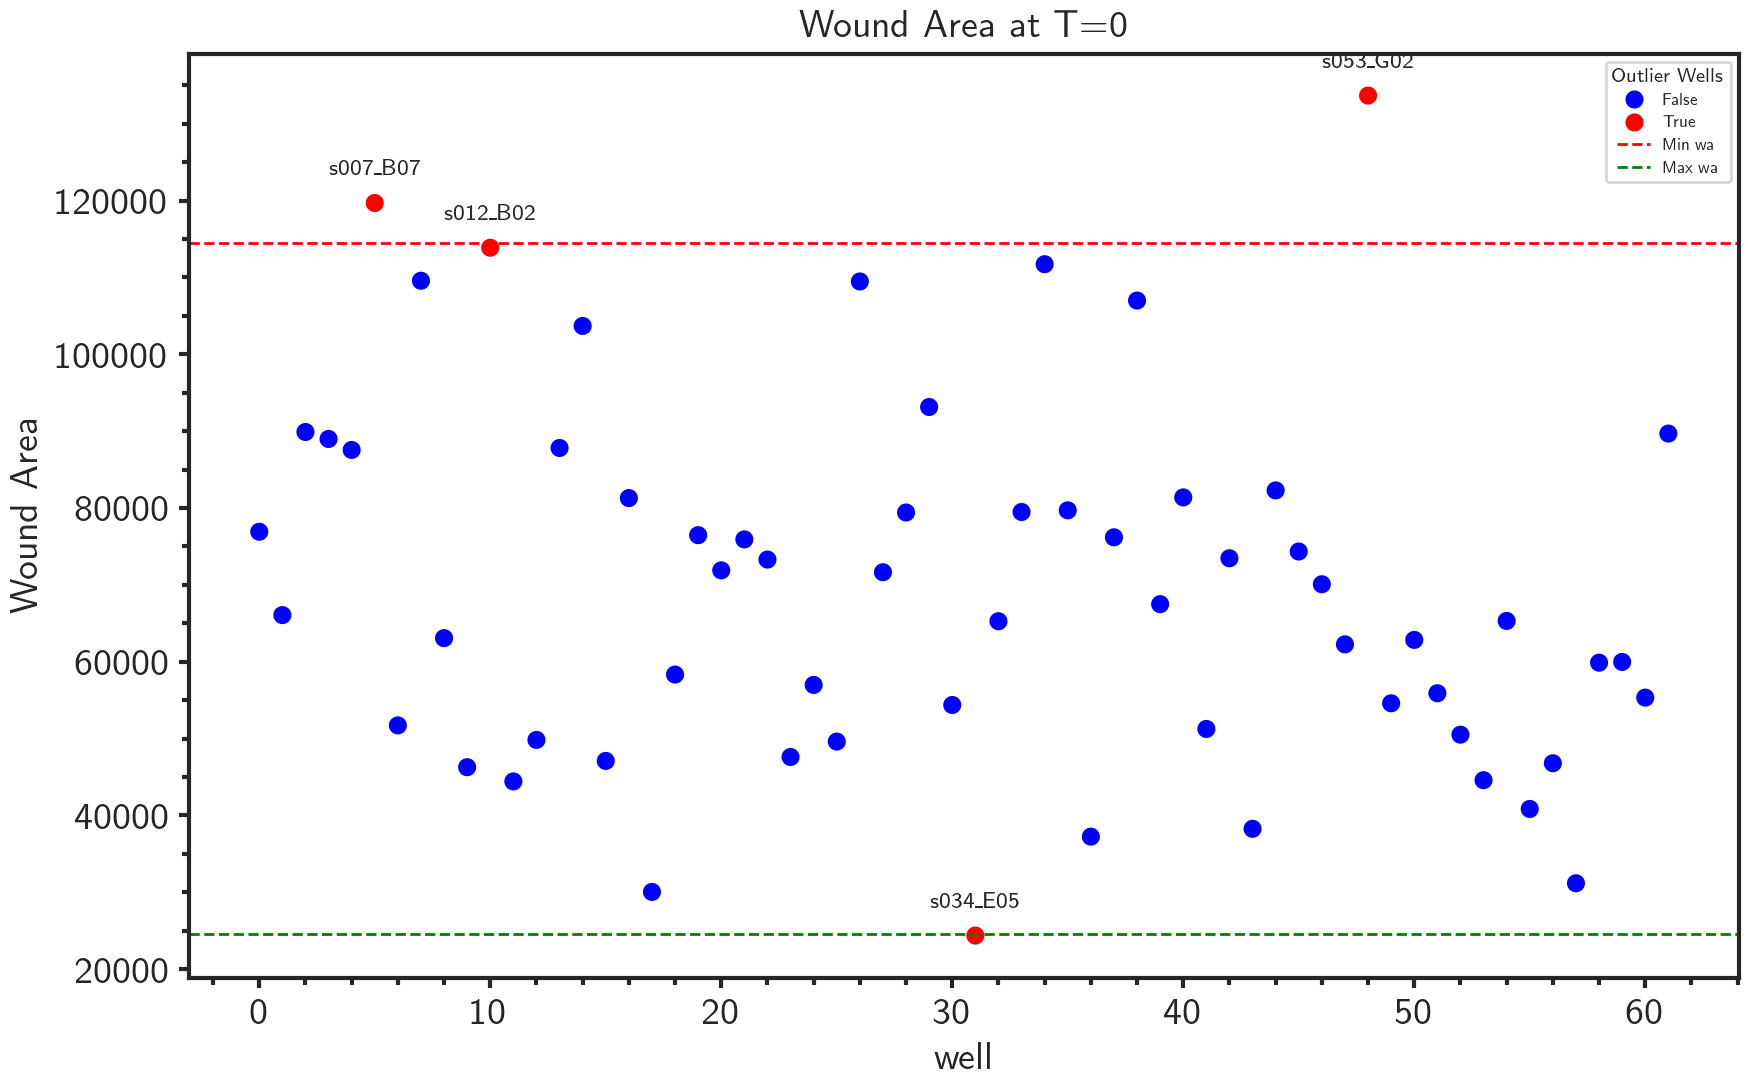

Finished processing R7P13_AI.xlsx.


In [11]:
# Create full file paths
file_paths = [os.path.join(dir_parent, file_name) for file_name in file_names]
print("Filenames to process:", file_names)

#Store extracted data in a dictionary addressable by file_name in file_names
extracted_data = {}
for file_name, file_path in zip(file_names, file_paths):
    print(f"Processing {file_name}...")
    extracted_data[file_name.split('.')[0]] = process_excel_files(file_name.split('.')[0],file_path)
    print(f"Finished processing {file_name}.")

# Extract cell type information for each filename
cell_type = pd.read_excel(os.path.join(dir_parent, 'cell_type_log.xlsx'), sheet_name='Sheet1')

Plotting outlier wells for R7P11_AI: ['s007_B12', 's056_G12']


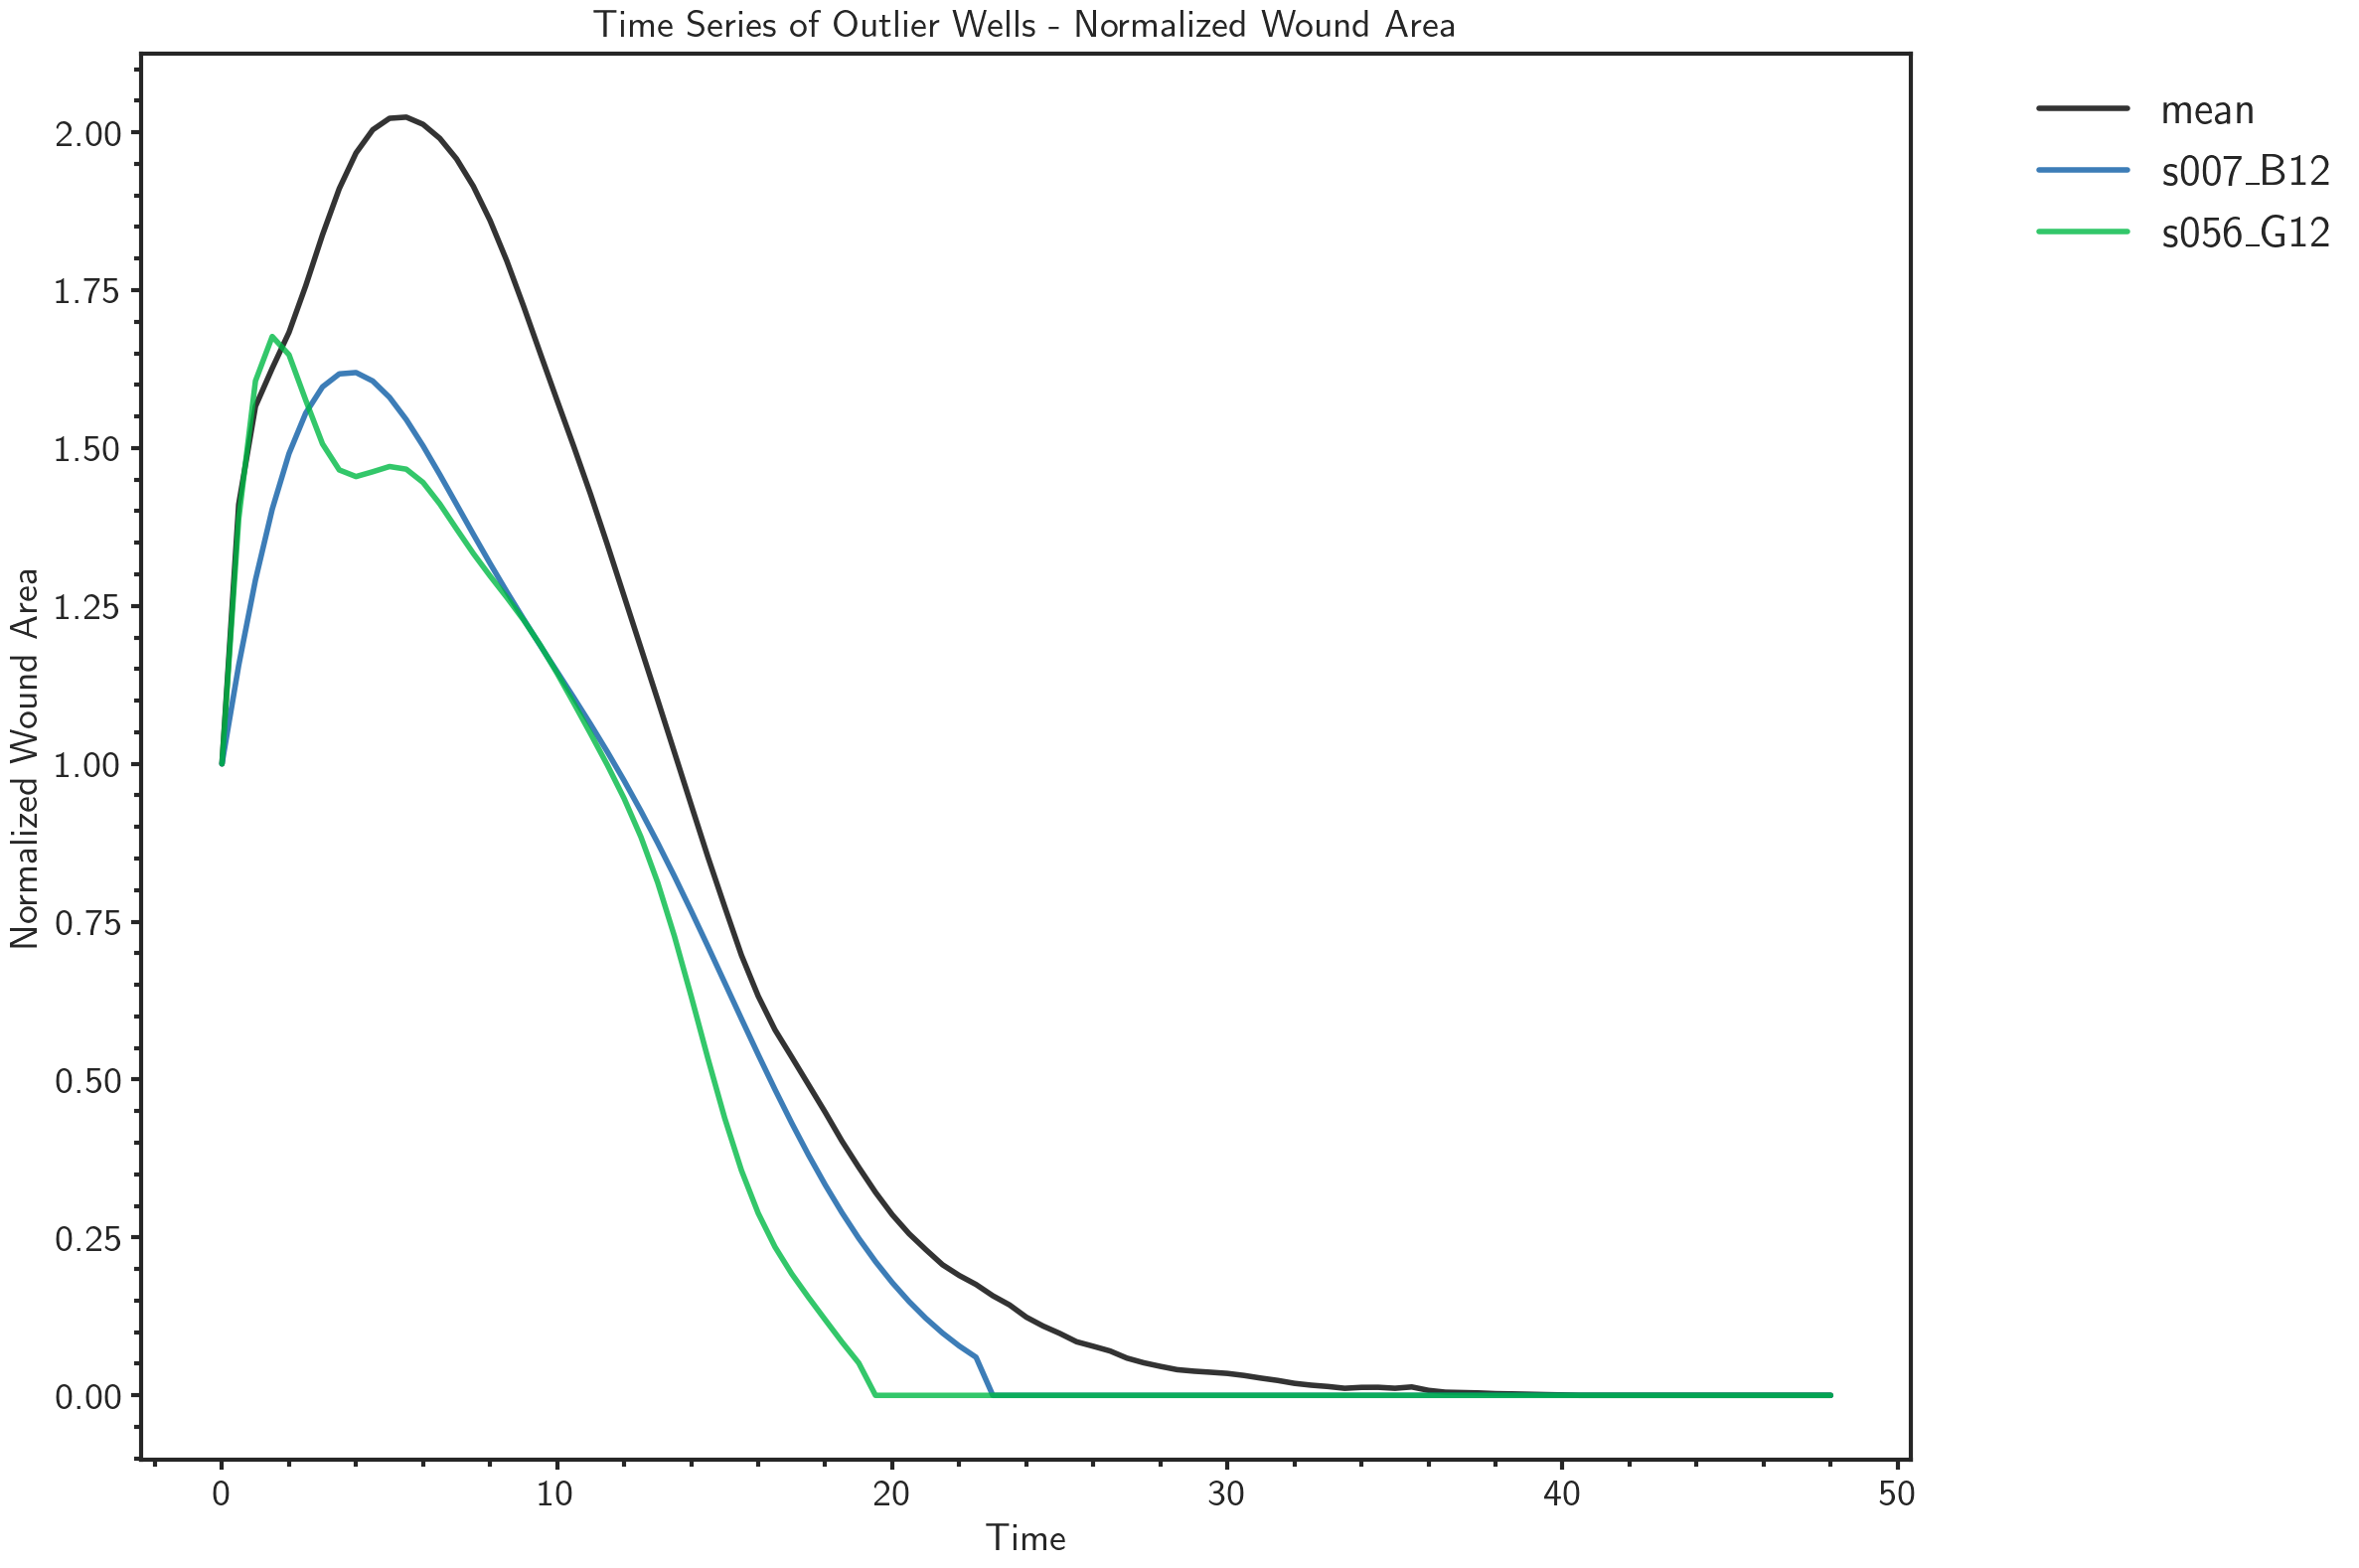

Plotting outlier wells for R7P13_AI: ['s007_B07', 's012_B02', 's034_E05', 's053_G02']


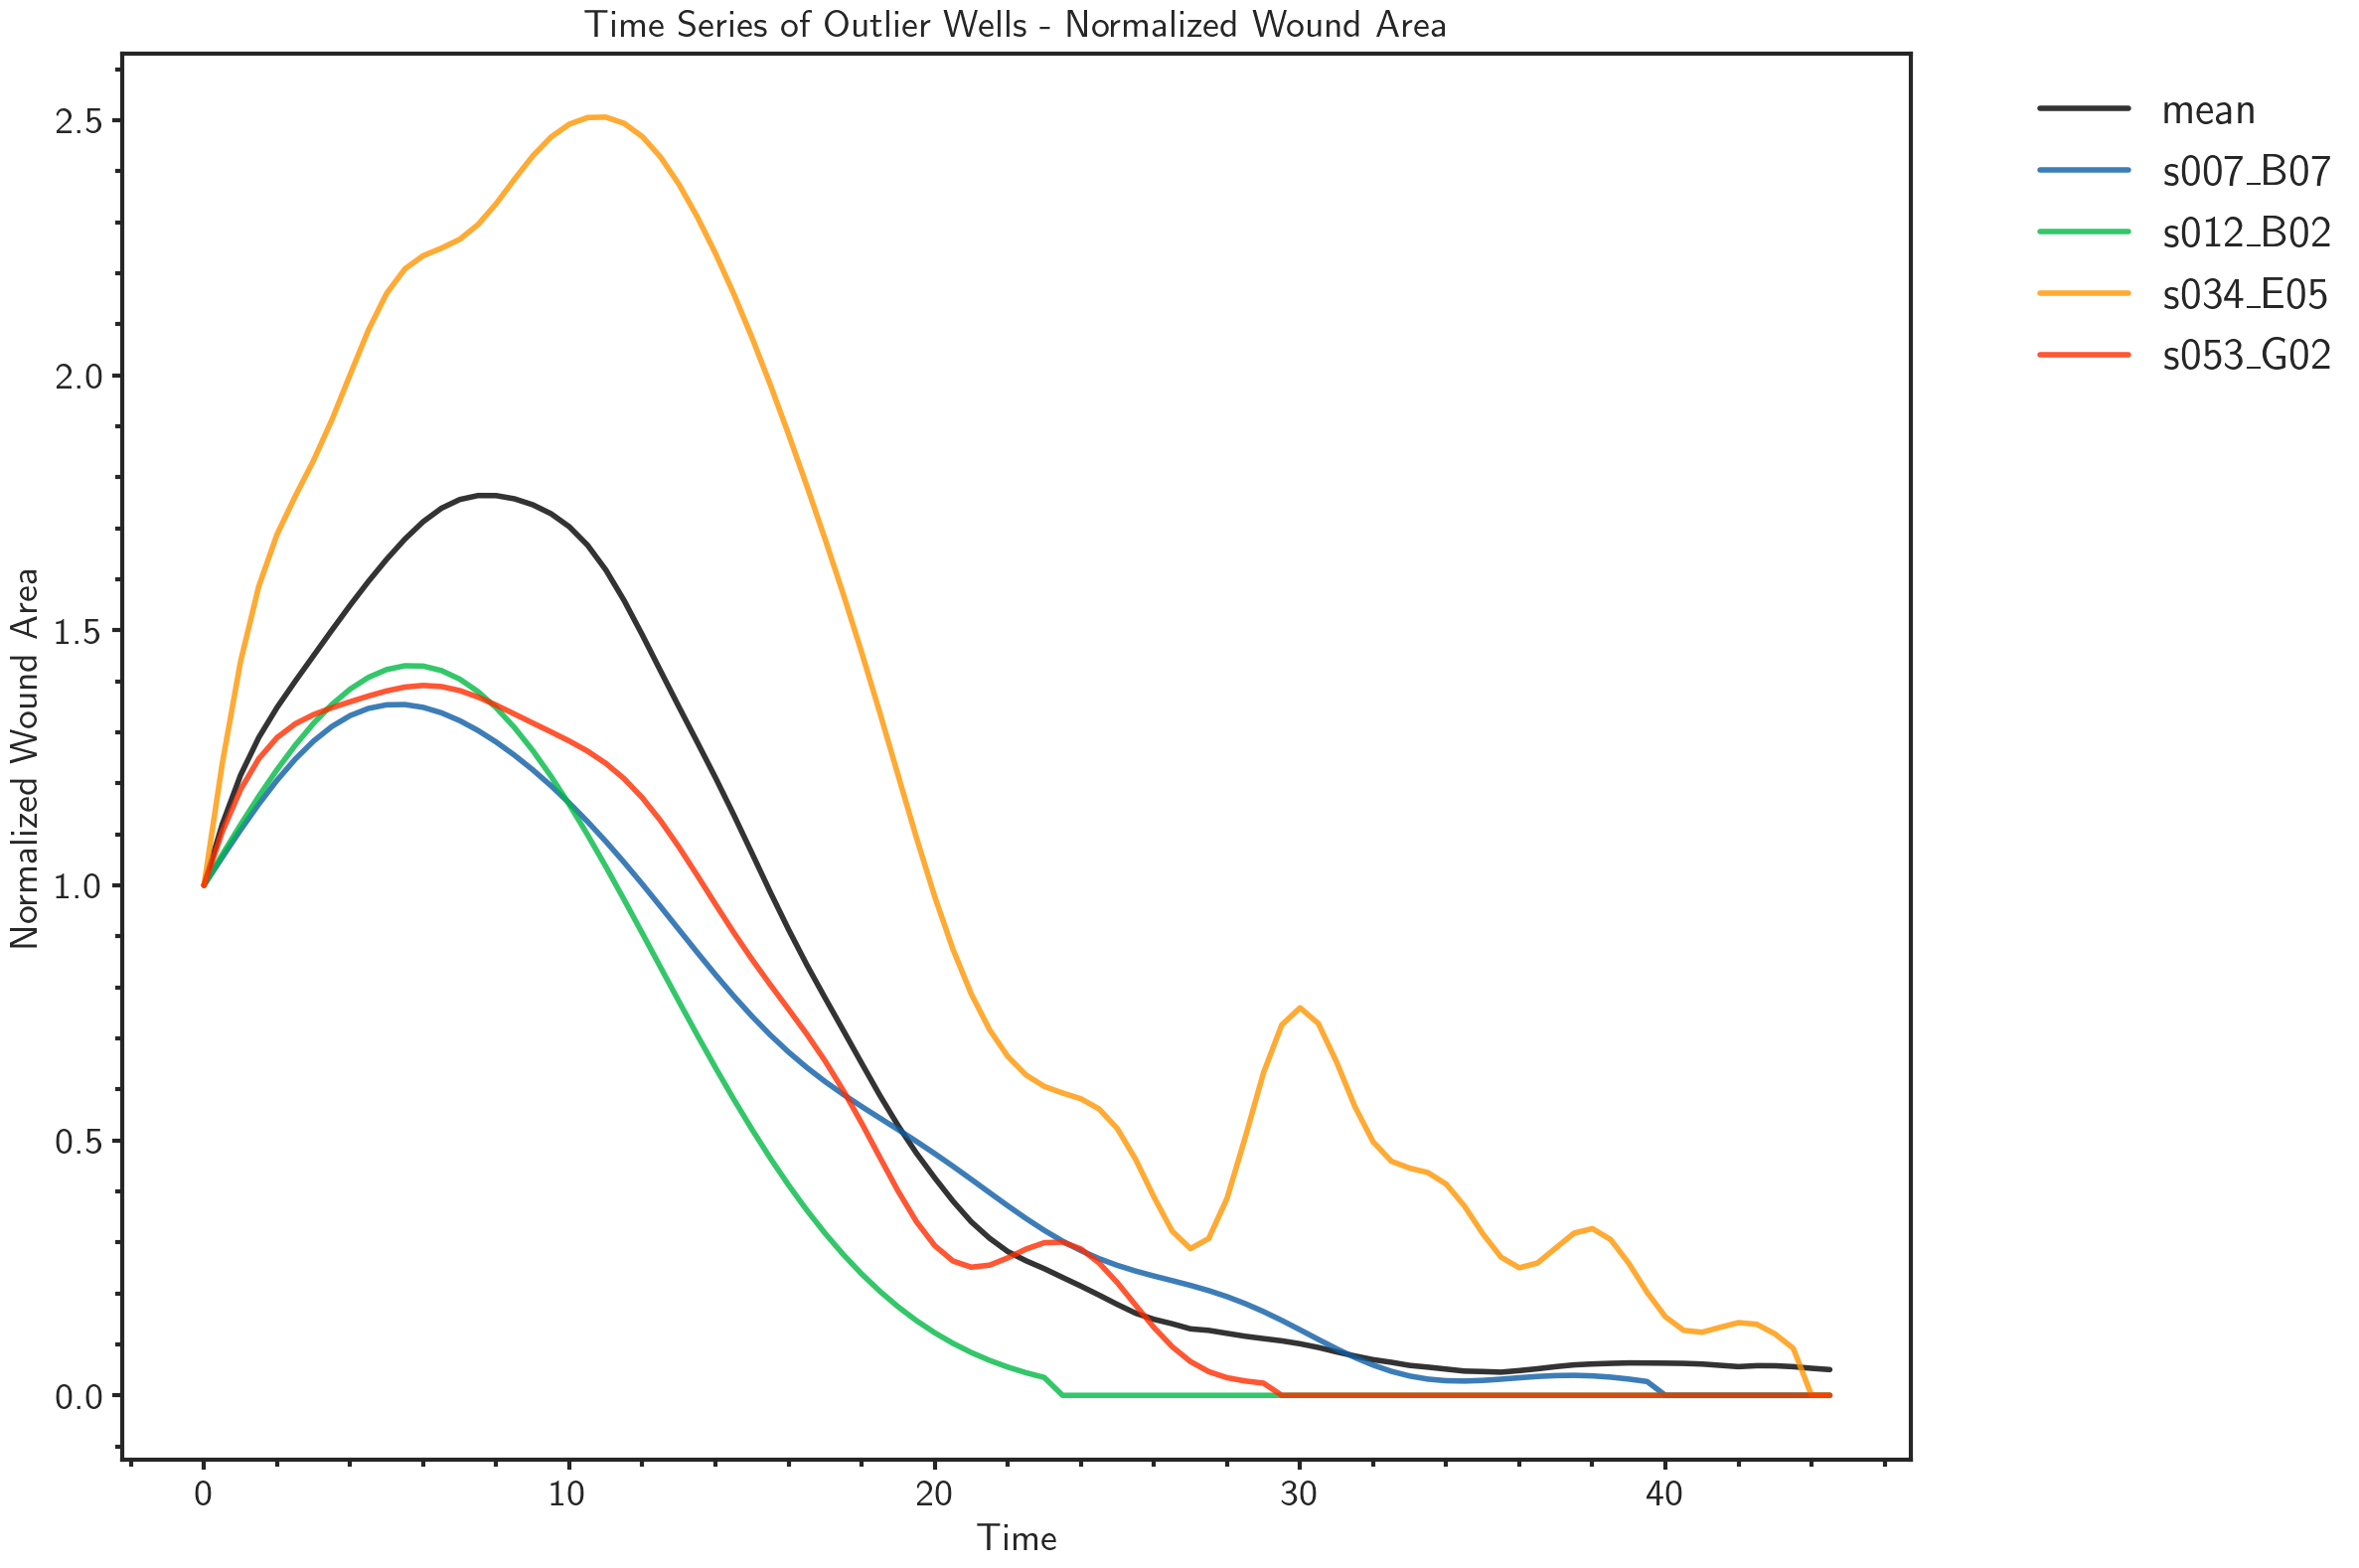

In [12]:
# Plot the time series for the outlier wells with a maximum of 5 lines per plot. If there are more than 5 outlier wells, it will create multiple plots.

for file_name, data in extracted_data.items():
    outlier_wells = data['outlier_wells']
    wound_area_normalized = data['wound_area_normalized']
    time_index = data['time_index']

    if outlier_wells:
        print(f"Plotting outlier wells for {file_name}: {list(outlier_wells.keys())}")
        plt.figure(figsize=(12, 8))
        plt.plot(time_index, wound_area_normalized.mean(axis=1), label='mean', color='black', linewidth=2, alpha=0.8)
        for well_name in outlier_wells.keys():
            # Find the full column name in wound_area_normalized that matches the outlier well
            matching_columns = [col for col in wound_area_normalized.columns if well_name in col]

            if matching_columns:
                well_column = matching_columns[0]

                plt.plot(time_index, wound_area_normalized[well_column],
                        label=f"{well_name}", linewidth=2, alpha=0.8)

        plt.xlabel('Time')
        plt.ylabel('Normalized Wound Area')
        plt.title('Time Series of Outlier Wells - Normalized Wound Area')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{file_name}_outlier_wells_timeseries.svg', format='svg', dpi=600, bbox_inches='tight')
        plt.show()




### Drop outliers

In [9]:
extracted_data = drop_outliers(extracted_data)

Dropping outlier wells for R7P11_AI: ['s007_B12', 's056_G12']
Dropping outlier wells for R7P13_AI: ['s007_B07', 's012_B02', 's034_E05', 's053_G02']


In [10]:
# Calculate outliers based on wound area filtered


### Reshape Data to human readable format and long format for plotting

#### Human Readable Format

In [13]:
# Make a combined dataset of all the conditions in the extracted_data dictionary.
dict_combined_conditions, combined_conditions_counts = combine_conditions(extracted_data)

#### Drop Conditions

In [14]:
#Drop unnecessary conditions
conditions_to_drop = ['bad device', 'seeding problem', 'Ctrl', 'Diclofenac','Ibuprofen','PDGF-BB_Old', 'Nintedanib_10uM', ]

for condition in conditions_to_drop:
    # Use exact case-insensitive matching
    keys_to_remove = [key for key in dict_combined_conditions.keys() if key.lower() == condition.lower()]

    if keys_to_remove:
        for key_to_remove in keys_to_remove:
            print(f"Removing '{key_to_remove}' condition from combined conditions and extracted data...")
            del dict_combined_conditions[key_to_remove]
            for experiment in extracted_data.keys():
                if key_to_remove in extracted_data[experiment]['dict_condition'].keys():
                    del extracted_data[experiment]['dict_condition'][key_to_remove]
            combined_conditions_counts = combined_conditions_counts.drop(key_to_remove, axis=0)

#### Long Format for Plotting

In [15]:
# Find the shortest time index in the extracted_data dictionary
# This is to ensure that the reshaped data has the same time index as the original data
# Return the key with the shortest time index
shortest_time_index = min(extracted_data.keys(), key=lambda k: len(extracted_data[k]['time_index']))
# Reshape the combined condition dictionary
reshaped_data = reshape_combined_conditions(extracted_data, extracted_data[shortest_time_index]['time_index'],cell_type)

### Plot Time Series Data

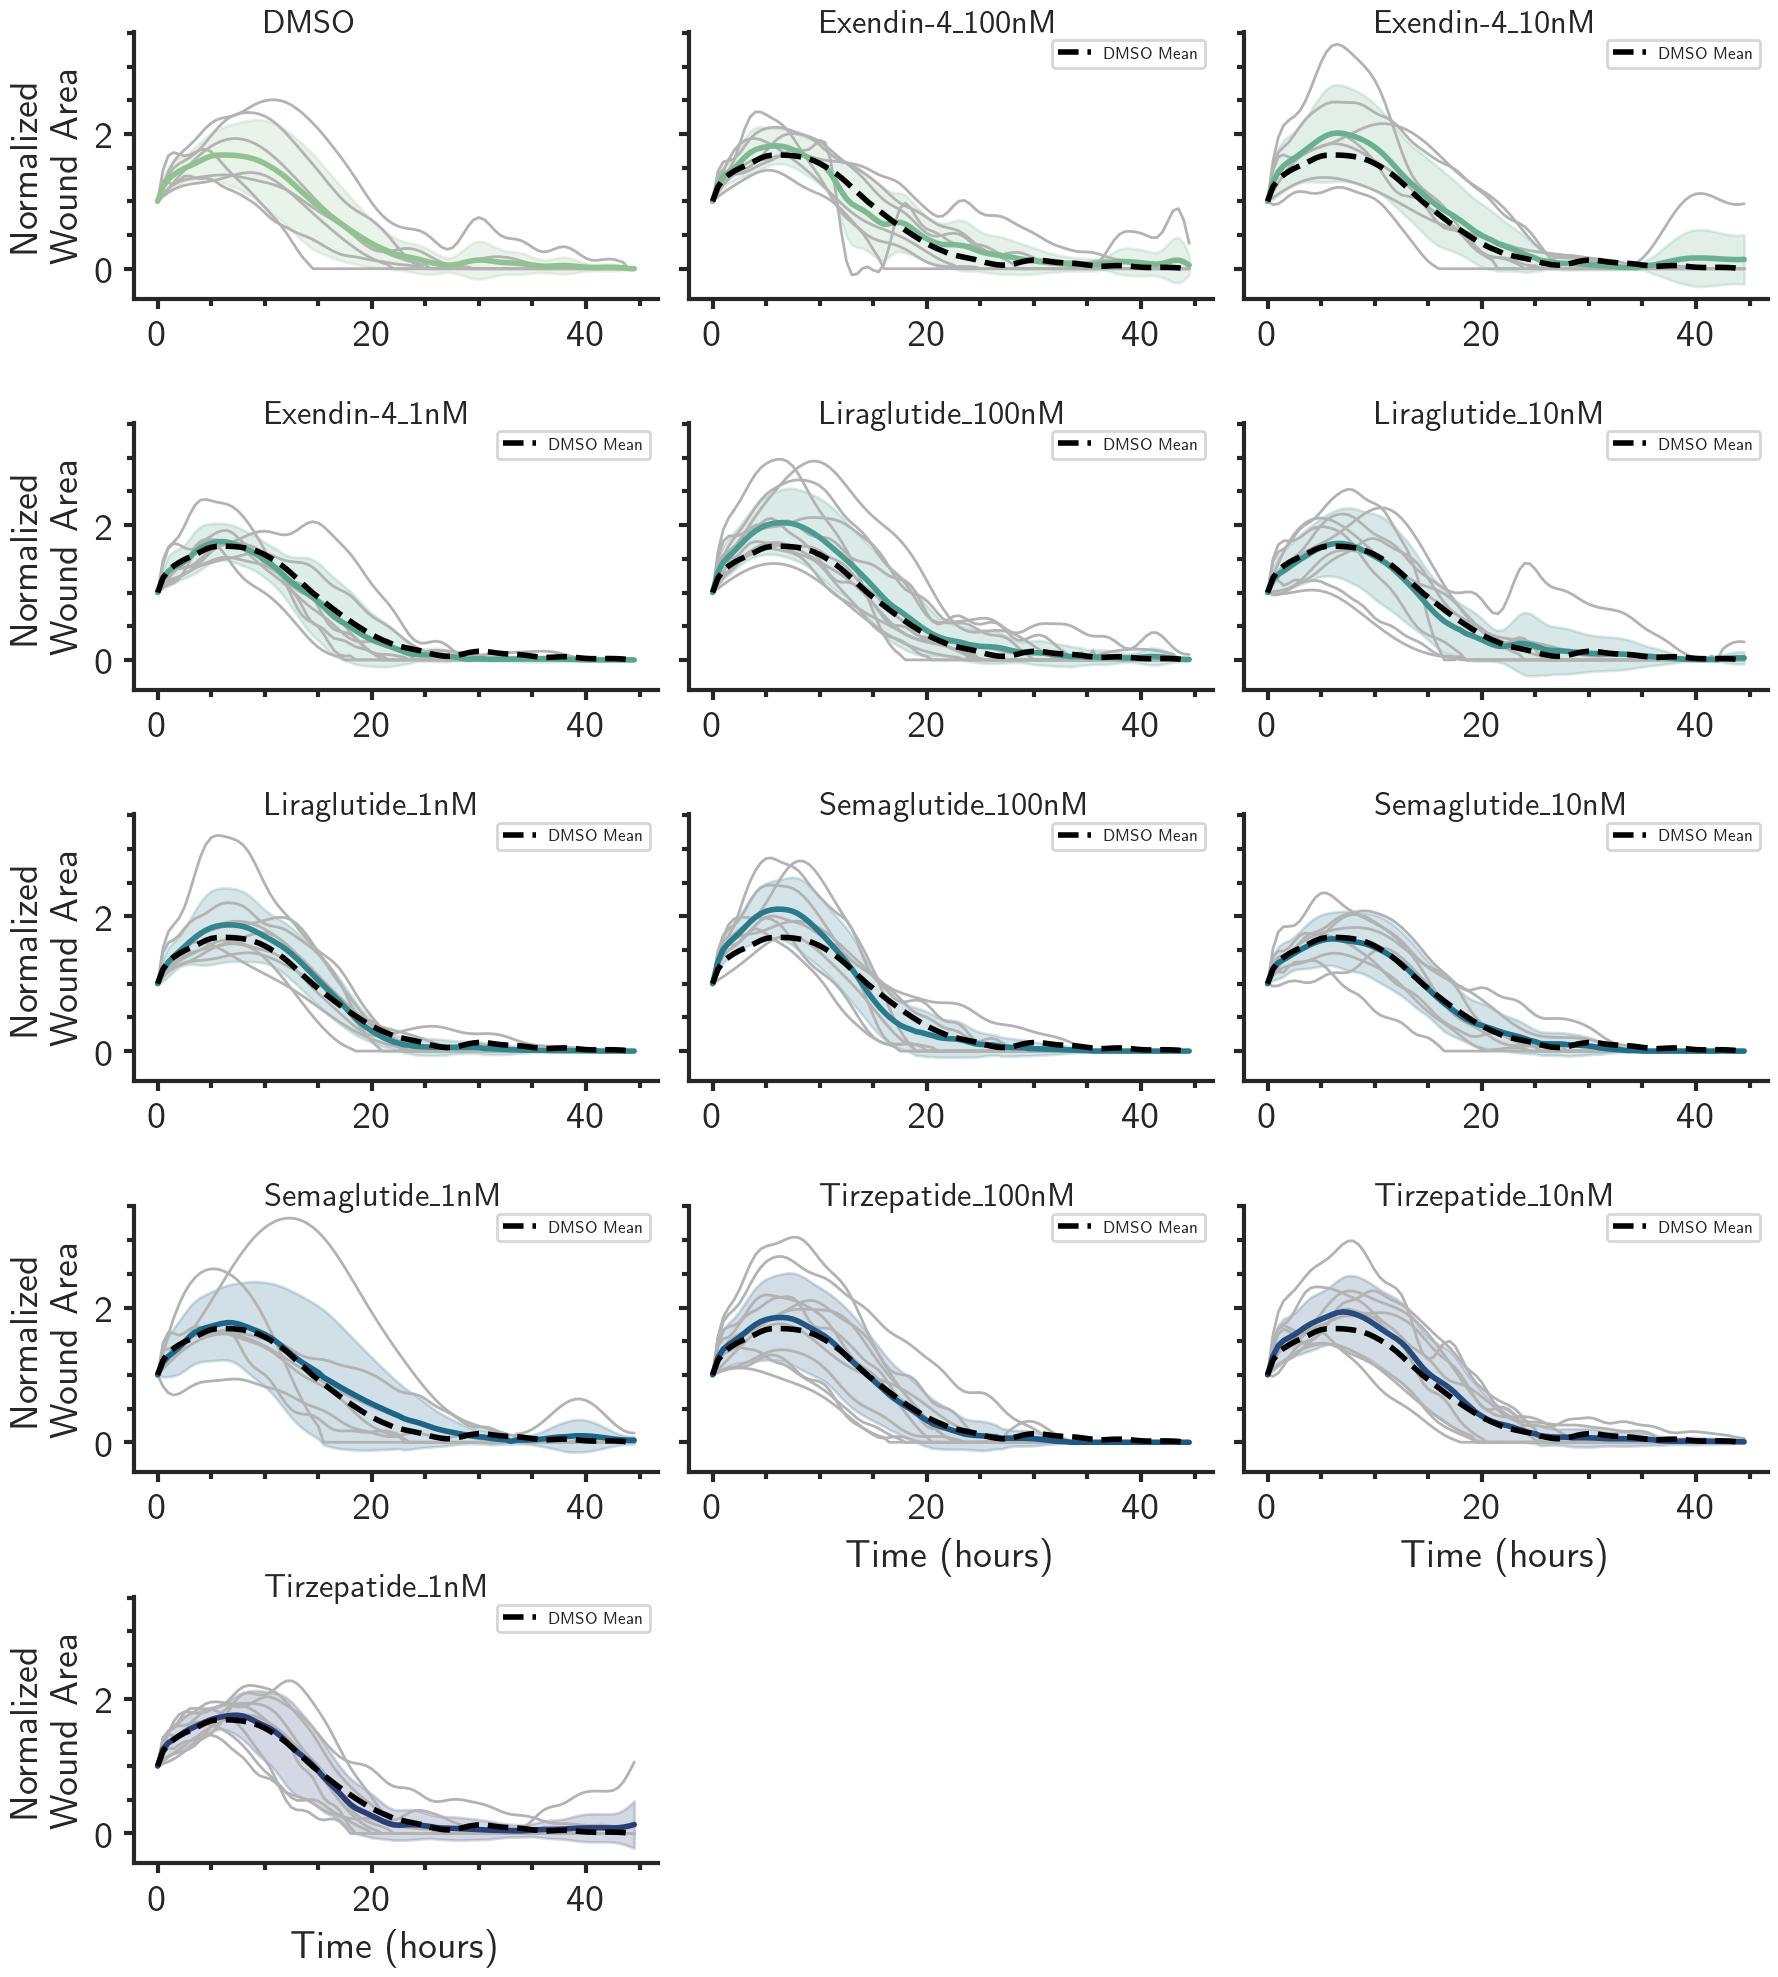

In [16]:
# Plotting the time series data using seaborn
# Plot average time series with individual wells in lighter color
# Sort the data into alphabetical order for plotting. Put DMSO and PDGF-BB as the first two conditions followed by the others in alphabetical order.
# Define priority controls
first = 'DMSO'
second = 'PDGF-BB-10 ng'

# All unique conditions
all_conditions = sorted(dict_combined_conditions.keys())

# Keep only existing controls (in case PDGF-BB absent)
present_controls = [c for c in [first, second] if c in all_conditions]

# Remaining (exclude controls), sorted
remaining = sorted([c for c in all_conditions if c not in present_controls])

# Final ordered list
ordered_conditions = present_controls + remaining


g = sns.relplot(
    data=reshaped_data,
    x="time_index", y="wound_area_normalized", col="condition_map", hue="condition_map",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,errorbar = "sd", col_order=ordered_conditions,
    hue_order=ordered_conditions,
    facet_kws={'sharex': False, 'sharey': True}
)

# Calculate the mean wound area for the control group to plot as a reference line
mean_control_group = reshaped_data[reshaped_data['condition_map'] == control_group_name].groupby('time_index')['wound_area_normalized'].mean().reset_index()

# Iterate over each subplot to customize further
for condition, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.25, 1, condition, transform=ax.transAxes, fontweight="bold", fontsize=12)

    # Filter data for only the current condition
    condition_data = reshaped_data[reshaped_data['condition_map'] == condition]
    # Plot every condition's time series in the background. Color code them according to the experiment they belong to (exp)
    # sns.lineplot( data=condition_data, x='time_index', y='wound_area', units='exp', alpha=0.5, legend=False, ax=ax, zorder=1)

    sns.lineplot(
        data=condition_data, x='time_index', y='wound_area_normalized', units='well', estimator=None, color='0.7', legend=False, ax=ax, zorder=1
    )

    # Plot DMSO mean line (skip if current condition is DMSO itself)
    if condition != 'DMSO':
        #print('Plotting DMSO mean line for condition:', condition)
        ax.plot(mean_control_group['time_index'], mean_control_group['wound_area_normalized'], color='black', linewidth=2, linestyle='--', alpha=1, label='DMSO Mean',zorder=20)
        # Add a legend for the DMSO mean line
        ax.legend(loc='upper right', fontsize='small',
                  title_fontsize='medium', frameon=True, shadow=False, fancybox=True)

# Set labels and layout
g.set_titles("")
g.set_axis_labels("Time (hours)", "Normalized \n Wound Area")

plt.savefig('average_plot_with_std_seaborn.svg', dpi=600)
g.tight_layout()
plt.show()

In [ ]:
# Plot 1 condition's lines with individual wells labelled using seaborn
condition_to_plot = 'DMSO'
cond_data = reshaped_data[reshaped_data['condition_map']==condition_to_plot ]

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=cond_data,
    x='time_index',
    y='wound_area_normalized',
    hue='well',
    linewidth=2,
    alpha=0.8
)



plt.xlabel('Time')
plt.ylabel('Normalized Wound Area')
plt.title(f'{condition_to_plot} Wells: Individual Time Series with Labels')
plt.legend(loc='upper left', fontsize='small', title='Wells')
plt.tight_layout()
plt.savefig(f'{condition_to_plot}_wells_labeled_seaborn.svg', dpi=600)
plt.show()


In [ ]:
# --- Find wells with wound area > 0 after t=25 ---
t_filter = 5
# Filter the data for the time period after 25 hours
data_after_t25 = cond_data[cond_data['time_index'] > t_filter]

# From that subset, find the wells that still have a wound area greater than 0
unclosed_wells_data = data_after_t25[data_after_t25['wound_area_normalized'] > 0]

# Get the unique list of well names
unclosed_wells = unclosed_wells_data['well'].unique()

if unclosed_wells.size > 0:
    print(f"For the condition '{condition_to_plot}', the following wells have a normalized wound area > 0 after t=25 hours:")
    for well in unclosed_wells:
        print(f"- {well}")
else:
    print(f"For the condition '{condition_to_plot}', no wells have a normalized wound area > 0 after t=25 hours.")

# Optional: Display the last few data points for these specific wells to verify
if unclosed_wells.size > 0:
    data_at_t25_unclosed = cond_data[
        (cond_data['time_index'] == t_filter) &
        (cond_data['well'].isin(unclosed_wells))
    ]

    if not data_at_t25_unclosed.empty:
        print(f"\nNormalized wound area at t={t_filter} hours for unclosed wells:")
        for _, row in data_at_t25_unclosed.iterrows():
            print(f"- {row['well']}: {row['wound_area_normalized']:.4f}")
    else:
        print(f"\nNo data found exactly at t={t_filter} hours for unclosed wells.")

### Data Exploration

In [ ]:


import pandas as pd
import numpy as np
from scipy.integrate import trapezoid
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

# --- Configuration ---
alpha = 0.05
response_col = 'wound_area_normalized'
time_col = 'time_index'
group_col = 'condition_map'
id_cols = ['well', group_col, 'exp']

# --- 1. Compute AUC per well ---
def compute_auc(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values(time_col)
    val = trapezoid(g[response_col].to_numpy(), g[time_col].to_numpy())
    return pd.Series({'auc': val})

auc_data = (
    reshaped_data
    .groupby(id_cols, as_index=False)
    .apply(compute_auc)
)

auc_data['auc']=auc_data['auc']*(0.889*0.889)


### Calculate and Drop AUC outliers

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for AUC in each condition
q1 = auc_data.groupby('condition_map')['auc'].quantile(0.25)
q3 = auc_data.groupby('condition_map')['auc'].quantile(0.75)

# Calculate the IQR by subtracting Q1 from Q3
iqr_by_condition = (q3 - q1).reset_index(name='auc_iqr')

print("IQR for AUC by condition:")
print(iqr_by_condition)

print("Old Shape: ", auc_data.shape)

# Calculate group-wise statistics and broadcast them to the original DataFrame's shape
grouped_auc = auc_data.groupby('condition_map')['auc']
group_means = grouped_auc.transform('mean')
# Use lambda functions for quantile to ensure compatibility with transform
group_q1 = grouped_auc.transform(lambda x: x.quantile(0.25))
group_q3 = grouped_auc.transform(lambda x: x.quantile(0.75))
group_iqr = group_q3 - group_q1

# Calculate the upper and lower bounds for each data point based on its group
lower_bounds = group_means - 1.5 * group_iqr
upper_bounds = group_means + 1.5 * group_iqr

# Identify outliers by creating a boolean mask
is_outlier = (auc_data['auc'] < lower_bounds) | (auc_data['auc'] > upper_bounds)
print(f"Identified {is_outlier.sum()} outliers to remove.")

# Remove outliers by keeping rows that are NOT outliers.
# Using .copy() is good practice to avoid SettingWithCopyWarning later.
auc_data = auc_data[~is_outlier].copy()

print("New Shape: ", auc_data.shape)


In [ ]:

# Rename columns for convenience
auc_data.columns = ['SampleID', 'Condition', 'SampleGroup', 'AUC']

In [ ]:
# --- Configuration ---
alpha = 0.05
response_col = 'wound_area_normalized'
time_col = 'time_index'
group_col = 'condition_map'
id_cols = ['well', group_col, 'exp']



import pandas as pd
import numpy as np
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import string
import networkx as nx
# Load data


# Kruskal-Wallis Test across groups
groups = auc_data['Condition'].unique()
data_groups = [auc_data.loc[auc_data['Condition'] == g, 'AUC'].values for g in groups]
h_stat, p_kw = stats.kruskal(*data_groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}, p-value: {p_kw:.4f}")

# Post-hoc Dunn test vs control (DMSO) with Bonferroni correction
control = 'DMSO'
# Dunn's test from scikit-posthocs offers pairwise p-values for all groups; we extract pairwise vs control
dunn_res = sp.posthoc_dunn(auc_data, val_col='AUC', group_col='Condition', p_adjust='bonferroni')

# Extract p-values comparing each group vs control
p_values_vs_control = dunn_res.loc[control].drop(control)

# Determine significance and direction
group_means = auc_data.groupby('Condition')['AUC'].mean()
significance = {}
alpha = 0.05
for g, pval in p_values_vs_control.items():
    if pval < alpha:
        # Determine if larger or smaller than control mean
        if group_means[g] > group_means[control]:
            significance[g] = 'larger'
        else:
            significance[g] = 'smaller'
    else:
        significance[g] = 'ns'  # not significant

# Add control group status
significance[control] = 'control'

# Ensure all conditions have a significance entry (if missing, assign 'ns')
unique_conditions = auc_data['Condition'].unique()
for cond in unique_conditions:
    if cond not in significance:
        significance[cond] = 'ns'

# Define color mapping for significance categories
palette_map = {
    'control': 'blue',
    'larger': 'red',
    'smaller': 'green',
    'ns': 'grey'
}

# Build full palette dictionary for all conditions based on significance
palette = {cond: palette_map[significance[cond]] for cond in unique_conditions}

# Map colors to DataFrame for plotting
auc_data['Color'] = auc_data['Condition'].map(palette)

# Prepare compact letter display (CLD) - assign letters so groups with no significant difference share letters
# We'll create pairwise significance matrix to generate CLD
# Make a boolean matrix for significant differences (True = significantly different)
sig_matrix = dunn_res.copy()
sig_matrix = sig_matrix.applymap(lambda p: p < alpha if not np.isnan(p) else False)

# For CLD, groups not significantly different share letter; we'll invert significance to non-significance matrix
nsgn_matrix = ~sig_matrix

# CLD function


def multi_letter_cld_graph(no_sig_matrix):
    """
    Generate multi-letter CLD using maximal cliques in the no-significance graph.
    no_sig_matrix: pd.DataFrame, symmetric boolean matrix (True=no significant difference)
    Returns: dict mapping group->multi-letter string (e.g., 'ab', 'c', etc.)
    """
    groups = no_sig_matrix.index.tolist()
    # Build graph where an edge exists if two groups are NOT significantly different (True)
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(groups)

    # Add edges for True in no_sig_matrix excluding self-loops
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            if i < j and no_sig_matrix.loc[g1, g2]:
                G.add_edge(g1, g2)

    # Find maximal cliques (complete subgraphs)
    cliques = list(nx.find_cliques(G))

    # Assign letters to cliques
    letters = list(string.ascii_lowercase)
    letter_cliques = {letters[i]: cliques[i] for i in range(len(cliques)) if i < len(letters)}

    # Assign letters to groups: each group collects letters for cliques it belongs to
    cld_map = {g: '' for g in groups}
    for letter, clique in letter_cliques.items():
        for g in clique:
            cld_map[g] += letter

    # Sort letters in each string for readability
    for g in cld_map:
        cld_map[g] = ''.join(sorted(cld_map[g]))

    return cld_map

cld_multi = multi_letter_cld_graph(nsgn_matrix)
# To see assigned multi-letter CLD per group
for group, letters in cld_multi.items():
    print(f"{group}: {letters}")
# Add CLD to dataframe for plotting labels
cld_df = pd.DataFrame({
    'Condition': ordered_conditions,
    'CLD': [cld_multi[g] for g in ordered_conditions]
})
# cld_multi = pd.read_excel('D:\\OneDrive\\Boston University\\OneDrive - Boston University\\Desktop\\CLD.xlsx', sheet_name='Sheet1')
# cld_multi = dict(zip(cld_multi['Condition'], cld_multi['CLD']))

# Plot boxplot + swarmplot with colors coded by significance
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Condition', y='AUC', data=auc_data, palette=palette, order=ordered_conditions, fliersize=10)
sns.swarmplot(x='Condition', y='AUC', data=auc_data, color='black', edgecolor='gray', size=5, order=ordered_conditions)

# Add CLD letters above max points
max_vals = auc_data.groupby('Condition')['AUC'].max()
for i, cond in enumerate(ordered_conditions):
    y = max_vals[cond]
    cld_text = cld_multi.get(cond, '')
    ax.text(i, y + 1, cld_text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

plt.axhline(y=auc_data.loc[auc_data['Condition'] == 'DMSO', 'AUC'].median(), color='r', linestyle='--')
ax.set_ylim(0,67)
ax.set_title('AUC by Condition with Dunn-Bonferroni Post-hoc Test CLD')
ax.set_xlabel('Condition')
ax.set_ylabel('AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('AUC_by_Condition.svg')
plt.show()



# ax.set_xlabel('Condition')
# ax.set_ylabel('AUC (micron sq. * hours)')
# ax.set_title('AUC by Condition with FDR (two-stage BKY) Compact Letter Display')
# plt.xticks(rotation=45, ha='right' )
# ax.tick_params(bottom=True, left=True)
# ax.xaxis.set_minor_locator(NullLocator())
#
# # Format the y-axis to use scientific notation for large values
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#
# plt.tight_layout()
# plt.savefig('AUC_by_Condition.svg', dpi=300)
# plt.show()

In [ ]:
from itertools import combinations

def dunn_bonferroni_cld(data, group_col, value_col, alpha=0.05):
    # Step 1: Compute pairwise Dunn’s test with Bonferroni correction
    pvals = sp.posthoc_dunn(data, val_col=value_col, group_col=group_col, p_adjust='bonferroni')
    groups = pvals.columns.tolist()
    significance = pvals <= alpha

    # Step 2: Build the significance map
    sig_map = {g: set() for g in groups}
    for g1, g2 in combinations(groups, 2):
        if significance.loc[g1, g2]:
            # g1/g2 are significantly different
            sig_map[g1].add(g2)
            sig_map[g2].add(g1)

   # Step 3: Initialize letter assignments
    letter_assignments = {g: set() for g in groups}
    letters = []

    # Function that checks if a candidate letter can be assigned to a given set of groups
    def can_assign(letter_groups, candidate_group):
        # Candidate group must NOT be significantly different from any group that already has this letter
        for assigned_group in letter_groups:
            if sig_matrix.loc[candidate_group, assigned_group]:
                return False
        return True

    # Step 4: Assign letters (A, B, C, ...) until all groups are fully covered
    current_letter = 'A'
    groups_left = set(groups)
    while groups_left:
        letter_groups = set()
        # Try to assign letter to as many groups as possible without violating significance
        for g in groups:
            if g in groups_left and can_assign(letter_groups, g):
                letter_groups.add(g)
        # Assign current letter to all compatible groups found
        for g in letter_groups:
            letter_assignments[g].add(current_letter)
            groups_left.discard(g)
        letters.append((current_letter, letter_groups))
        # Move to next letter
        current_letter = chr(ord(current_letter) + 1)

    # Step 5: Convert set of letters into a sorted string for each group
    cld_labels = {g: ''.join(sorted(letter_assignments[g])) for g in groups}

    return cld_labels, pvals

cld_lab, pval2 = dunn_bonferroni_cld(auc_data, 'Condition', 'AUC', alpha=0.05)


In [ ]:
def assign_letters_from_pvals(pvals_df, alpha=0.05):
    groups = pvals_df.columns.tolist()
    # Significance matrix (True if significantly different)
    sig_matrix = (pvals_df <= alpha).values.astype(bool)
    n = len(groups)

    # We want non-significant pairs matrix
    nonsig_matrix = ~sig_matrix
    for i in range(n):
        nonsig_matrix[i, i] = True  # group is always non-significant with itself

    # Initialize letter assignments structure
    letter_assignments = {g: set() for g in groups}
    letters = []
    current_letter = ord('A')

    # Keep track of groups that still need coverage of all non-significant relationships
    covered_pairs = set()

    # Generate all group pairs
    all_pairs = set(combinations(range(n), 2))

    # While not all pairs have been covered by letters disallowing significant differences sharing letters
    while len(covered_pairs) < len(all_pairs):
        # Find largest subset of groups that are mutually non-significant respecting uncovered pairs
        candidate_groups = set()
        for g in range(n):
            # Try adding group g if it doesn't introduce significant comparisons with the candidate set
            if all(nonsig_matrix[g, c] for c in candidate_groups):
                candidate_groups.add(g)
        # Assign current letter to candidate groups
        for g in candidate_groups:
            letter_assignments[groups[g]].add(chr(current_letter))
        # Mark covered pairs among candidate groups
        new_pairs = set(combinations(candidate_groups, 2))
        covered_pairs.update(new_pairs)
        # Remove these groups temporarily and try again for others
        for g in candidate_groups:
            for other in range(n):
                # Mark these pairs as covered
                if g != other:
                    covered_pairs.add(tuple(sorted((g, other))))
        current_letter += 1

    # Convert letter sets to strings
    cld_labels = {g: ''.join(sorted(letters)) for g, letters in letter_assignments.items()}
    return cld_labels

cld_lab2 = assign_letters_from_pvals(pval2, alpha=0.05)

In [ ]:
#### b) Initial Healing Rate
# The initial slope of the curve indicates how quickly healing begins.
# We can calculate this by fitting a line to the early phase of healing.
from scipy.stats import linregress

# Define the time interval for rate calculation (e.g., first 10 hours)
rate_interval_end = 20
healing_rate_data = (
    reshaped_data[reshaped_data['time_index'] <= rate_interval_end]
    .groupby(['well', 'condition_map', 'exp'])
    .apply(lambda g: linregress(g['time_index'], g['wound_area_normalized']).slope)
    .reset_index(name='healing_rate')
)

# The slope is negative (area decreases), so we multiply by -1 to get a positive rate
healing_rate_data['healing_rate'] = healing_rate_data['healing_rate'] * -1

# --- Visualize using a Violin Plot to see the probability density of the data ---
plt.figure(figsize=(12, 7))
sns.violinplot(data=healing_rate_data, x='condition_map', y='healing_rate', palette='crest', inner='quartile')
sns.stripplot(data=healing_rate_data, x='condition_map', y='healing_rate', color='0.3', alpha=0.6)

plt.title(f'Initial Healing Rate (First {rate_interval_end} Hours)')
plt.ylabel('Healing Rate (Norm. Area Change / Hour)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
### Analysis Method 2: Add Statistical Annotations
# After creating summary plots, we can add statistical test results
# to quantify the significance of the differences between conditions.
# You may need to install statannot first:
# !pip install statannot
from statannotations.Annotator import Annotator

# Let's reuse the auc_data from before
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=auc_data, x='condition_map', y='auc', palette='viridis')

# Define pairs for comparison. Here, we compare every condition to the control group.
# Make sure `control_group_name` is defined as it was earlier in your notebook.
conditions = sorted(auc_data['condition_map'].unique())
box_pairs = [(control_group_name, cond) for cond in conditions if cond != control_group_name]

# Add annotations to the plot
# test='t-test_ind' performs an independent t-test.
# text_format='star' shows significance with asterisks (*: p < 0.05, etc.)
if box_pairs:
    annotator = Annotator(ax, box_pairs, data=auc_data, x='condition_map', y='auc')
    annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

plt.title('Healing Comparison by AUC with Statistical Significance')
plt.ylabel('AUC of Normalized Wound Area (Lower is faster)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
### Analysis Method 3: High-Level Heatmap Overview
# A heatmap provides a compact, matrix-based view of the entire experiment,
# making it easy to compare all conditions across all time points simultaneously.
# Pivot the data to create a matrix: conditions vs. time
heatmap_data = reshaped_data.pivot_table(
    index='condition_map',
    columns='time_index',
    values='wound_area_normalized',
    aggfunc='mean'
).sort_values(by=reshaped_data['time_index'].max(), ascending=True)  # Sort by final wound area

# --- Visualize the Heatmap ---
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    annot=False,
    cmap='viridis_r',  # '_r' reverses colormap; bright colors = smaller area = better healing
    linewidths=.5,
    cbar_kws={'label': 'Mean Normalized Wound Area'}
)

plt.title('Heatmap of Average Wound Healing Over Time')
plt.xlabel('Time (Hours)')
plt.ylabel('Condition')
plt.tight_layout()
plt.show()

In [ ]:
### Analysis Method 4: Explore Mechanical Data (Pillar Distances)
# The pillar distance data can reveal insights into the mechanical forces
# during healing. Let's see if it correlates with wound closure.
# First, melt the rpd columns to make them easier to work with
rpd_cols = [col for col in reshaped_data.columns if 'rpd_' in col]
if rpd_cols:
    reshaped_long_rpd = reshaped_data.melt(
        id_vars=['time_index', 'well', 'condition_map', 'wound_area_normalized'],
        value_vars=rpd_cols,
        var_name='pillar_id',
        value_name='pillar_distance'
    )

    # Calculate the mean pillar distance across all pillars for each well at each time point
    mean_rpd_data = reshaped_long_rpd.groupby(['time_index', 'well', 'condition_map', 'wound_area_normalized'])[
        'pillar_distance'].mean().reset_index()

    # --- Visualize: Scatter plot of Wound Area vs. Mean Pillar Distance, faceted by condition ---
    g = sns.relplot(
        data=mean_rpd_data,
        x='wound_area_normalized',
        y='pillar_distance',
        hue='time_index',
        col='condition_map',
        col_wrap=3,
        palette='viridis',
        height=3,
        aspect=1.2
    )

    g.fig.suptitle('Wound Area vs. Mean Pillar Distance Across Conditions', y=1.03)
    g.set_axis_labels('Normalized Wound Area', 'Mean Relative Pillar Distance')
    plt.tight_layout()
    plt.show()
else:
    print("No 'rpd_' columns found in reshaped_data to analyze.")


In [ ]:
### Feature Importance Analysis with Context
# Here, we expand the feature set to include not just the RPDs, but also the
# experimental condition and the time. This helps us understand the relative
# importance of the treatment itself compared to the mechanical changes it induces.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Prepare the data ---
# Select features, including categorical ones
features_context = reshaped_data.filter(regex='^rpd_').columns.tolist() + ['time_index', 'condition_map']
target_context = 'wound_area_normalized'

# Create a new DataFrame for this analysis
model_data = reshaped_data[features_context + [target_context]].copy()

# Drop rows where the target is NaN
model_data.dropna(subset=[target_context], inplace=True)

# Separate features (X) and target (y)
X = model_data[features_context]
y = model_data[target_context]

# --- Create a preprocessing pipeline ---
# This pipeline will handle missing values in numeric features and one-hot encode the categorical 'condition_map'
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['condition_map']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep other columns (if any)
)

# --- Define the full model pipeline ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# --- Train the model ---
model_pipeline.fit(X, y)

# --- Get and plot feature importances ---
# Get feature names after one-hot encoding
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(
    categorical_features)
all_feature_names = numeric_features + ohe_feature_names.tolist()

importances = model_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df_context = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importance_df_context = feature_importance_df_context.sort_values(by='importance', ascending=False)

# Plot the results
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df_context.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
### Predicting Healing Rate from Initial Mechanical State
# This analysis shifts the question from predicting a single time point to predicting
# an overall outcome for the well. We use the RPD values at the very beginning of the
# experiment (time = 0) to predict the overall healing rate.
# --- Prepare the data ---
# Get the initial RPD values at the first time point
initial_time = reshaped_data['time_index'].min()
initial_rpd_data = reshaped_data[reshaped_data['time_index'] == initial_time].copy()

# Select only the RPD columns and the well identifier
rpd_cols = initial_rpd_data.filter(regex='^rpd_').columns.tolist()
features_initial = initial_rpd_data[['well'] + rpd_cols]

# The healing_rate_data is already calculated, one value per well.
# Merge the initial features with the target (healing_rate)
rate_prediction_data = pd.merge(healing_rate_data, features_initial, on='well')

# Handle any potential missing values in the features
rate_prediction_data[rpd_cols] = rate_prediction_data[rpd_cols].fillna(rate_prediction_data[rpd_cols].mean())

# --- Train the model ---
X_rate = rate_prediction_data[rpd_cols]
y_rate = rate_prediction_data['healing_rate']

model_rate = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rate.fit(X_rate, y_rate)

# --- Get and plot feature importances ---
importances_rate = model_rate.feature_importances_
feature_importance_df_rate = pd.DataFrame({'feature': rpd_cols, 'importance': importances_rate})
feature_importance_df_rate = feature_importance_df_rate.sort_values(by='importance', ascending=False)

# Plot the results
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df_rate.head(15), palette='plasma')
plt.title('Importance of Initial RPDs for Predicting Overall Healing Rate')
plt.xlabel('Importance')
plt.ylabel('Initial RPD Feature (at t=0)')
plt.tight_layout()
plt.show()

## Other

In [ ]:
### Analysis Method 5: Time to 50% Closure (T50)
# This metric calculates the time required for each wound to heal to 50% of its initial area.
# A lower T50 value signifies a faster healing process. We use interpolation
# to get a precise estimate even if no data point falls exactly at 50%.
from scipy.stats import kruskal
import scikit_posthocs as sp
import cld4py

def calculate_t50(group):
    """Calculates the time to 50% closure for a single well."""
    # Ensure data is sorted by time
    group = group.sort_values('time_index')

    # Find the first point where area drops below 0.5
    if (group['wound_area_normalized'] <= 0.5).any():
        # Get the first index where condition is met
        first_half_idx = group[group['wound_area_normalized'] <= 0.5].index[0]

        # Get the index before it
        prev_idx = group.index[group.index.get_loc(first_half_idx) - 1]

        # Interpolate to find the exact time
        t1, a1 = group.loc[prev_idx, ['time_index', 'wound_area_normalized']]
        t2, a2 = group.loc[first_half_idx, ['time_index', 'wound_area_normalized']]

        # Avoid division by zero if areas are the same
        if a1 == a2:
            return t1

        # Linear interpolation: t = t1 + (t2 - t1) * (target_area - a1) / (a2 - a1)
        t50 = t1 + (t2 - t1) * (0.5 - a1) / (a2 - a1)
        return t50
    else:
        # Return NaN if the wound never closes to 50%
        return 36


# Calculate T50 for each well
t50_data = reshaped_data.groupby(['well', 'condition_map', 'exp']).apply(calculate_t50).reset_index(name='t50')

# Kruskal-Wallis test across conditions
groups = [group['t50'].values for name, group in t50_data.groupby('condition_map')]
kruskal_stat, kruskal_p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.4e}")

# Post-hoc Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(t50_data, val_col='t50', group_col='condition_map', p_adjust='bonferroni')

# Prepare pairwise p-values in long format for cld4py
pairs = []
conditions = dunn_results.index.tolist()
for i, cond1 in enumerate(conditions):
    for j, cond2 in enumerate(conditions):
        if j > i:
            pval = dunn_results.loc[cond1, cond2]
            pairs.append({'group1': cond1, 'group2': cond2, 'p_value': pval})
pairwise_df = pd.DataFrame(pairs)

# Generate compact letter display with cld4py.assign_letters
letters = cld4py.assign_letters(pairwise_df, 'group1', 'group2', 'p_value', alpha=0.05,
                               order=ordered_conditions, data=t50_data, vals='t50', group='condition_map')

# Plot with CLD annotations
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=t50_data, x='condition_map', y='t50', order=ordered_conditions)
sns.stripplot(data=t50_data, x='condition_map', y='t50', color='0', alpha=0.6, order=ordered_conditions)

# Add CLD letters to the plot using cld4py.plot_letters
cld4py.plot_letters(cld=letters, data=t50_data, figax=ax, axis='x', plot='boxplot',
                    pos='upper', vals='t50', group='condition_map', pad=1, c='black')

# Add horizontal median line for reference (DMSO)
plt.axhline(y=t50_data.loc[t50_data['condition_map'] == 'DMSO', 't50'].median(), color='black', linestyle='--')

plt.axhline(y=36, color='r', linestyle='--', label='Never closes <50%')
plt.title('Time to 50% Wound Closure (T50)')
plt.ylabel('Time (Hours)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Time to 50% Wound Closure (T50).svg')
plt.show()

In [ ]:
### Analysis Method 6: Final Wound Area (Residual Area)
# This metric measures the normalized wound area at the final time point,
# indicating how completely the wound has healed. A lower value is better.
# Find the last time point in the dataset
last_time_point = reshaped_data['time_index'].max()
last_time_point = 28
# Filter for the last time point and get the residual area
final_area_data = reshaped_data[reshaped_data['time_index'] == last_time_point].copy()

# --- Visualize the Final Wound Area ---
plt.figure(figsize=(12, 7))
sns.violinplot(data=final_area_data, x='condition_map', y='wound_area_normalized', palette='coolwarm', inner='quartile')
sns.stripplot(data=final_area_data, x='condition_map', y='wound_area_normalized', color='0.3', alpha=0.6)

plt.title(f'Residual Wound Area at {last_time_point} Hours')
plt.ylabel('Final Normalized Wound Area')
plt.xlabel('Condition')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Complete Closure')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
### Analysis Method 7: Maximum Healing Rate
# This metric identifies the peak healing speed at any point during the experiment.
# It's calculated by finding the steepest downward slope of the healing curve.
# This can capture delayed but rapid healing responses.
def calculate_max_rate(group):
    """Calculates the maximum healing rate for a single well."""
    # Ensure data is sorted by time
    group = group.sort_values('time_index')

    # Calculate the gradient (slope) of the wound area
    # np.gradient provides the slope at each point
    slopes = np.gradient(group['wound_area_normalized'], group['time_index'])

    # Healing rate is the negative of the slope (since area decreases)
    healing_rates = -slopes

    # Return the maximum rate
    return healing_rates.max()


# Calculate max healing rate for each well
max_rate_data = reshaped_data.groupby(['well', 'condition_map', 'exp']).apply(calculate_max_rate).reset_index(
    name='max_healing_rate')

# --- Visualize the Maximum Healing Rate ---
plt.figure(figsize=(12, 7))
sns.boxplot(data=max_rate_data, x='condition_map', y='max_healing_rate', palette='plasma')
sns.stripplot(data=max_rate_data, x='condition_map', y='max_healing_rate', color='0.3', alpha=0.6)

plt.title('Maximum Healing Rate During Experiment')
plt.ylabel('Max Healing Rate (Norm. Area Change / Hour)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Advanced Time Series Plot with Matched Controls
# This plot provides a more rigorous comparison by faceting by both cell type and condition.
# - For each condition, a "matched" control mean is plotted, using only data from experiments where that condition was present.
# - For the control condition itself, it plots the mean from each experiment to show inter-experiment variability.

In [ ]:
# --- 1. Create the main faceted plot structure ---
g = sns.relplot(
    data=reshaped_data,
    x="time_index",
    y="wound_area_normalized",
    row="cell_type",
    col="condition_map",
    kind="line",
    errorbar="sd",  # Show standard deviation for the main condition line
    height=3,
    aspect=1.3,
    legend=False,
    zorder=5
)

g.fig.suptitle('Wound Healing by Condition with Matched Experiment-Specific Controls', y=1.05, fontsize=16)

# --- 2. Iterate over each subplot to add custom layers ---
for (cell_type, condition), ax in g.axes_dict.items():

    # Filter data for the current subplot
    subplot_data = reshaped_data[
        (reshaped_data['cell_type'] == cell_type) &
        (reshaped_data['condition_map'] == condition)
    ]

    # If there is no data for this specific combination of cell_type and condition,
    # hide the subplot and skip to the next iteration.
    if subplot_data.empty:
        ax.set_visible(False)
        continue
    # Plot individual well traces in the background for context
    sns.lineplot(
        data=subplot_data, x='time_index', y='wound_area_normalized',
        units='well', estimator=None, color='0.7', alpha=0.5, legend=False, ax=ax, zorder=1
    )

    # --- 3. Apply special plotting logic based on condition ---
    if condition == control_group_name:
        # For the control's own plot, show the mean line for each experiment to visualize variability
        sns.lineplot(
            data=subplot_data, x='time_index', y='wound_area_normalized',
            hue='exp', ax=ax, legend='full', zorder=10
        )
        ax.set_title(f"{condition} (by Exp)")
        ax.legend(loc='upper left', title='Experiment')

    else:
        # For all other conditions, plot a matched control reference line
        # Find which experiments are present in this non-control subplot
        experiments_in_condition = subplot_data['exp'].unique()

        # Filter the full dataset to get control data ONLY from those same experiments and cell type
        matched_control_data = reshaped_data[
            (reshaped_data['cell_type'] == cell_type) &
            (reshaped_data['condition_map'] == control_group_name) &
            (reshaped_data['exp'].isin(experiments_in_condition))
        ]

        # If we found matching control data, plot its mean as a reference line
        if not matched_control_data.empty:
            ax.plot(
                matched_control_data.groupby('time_index')['wound_area_normalized'].mean(),
                color='black', linewidth=2, linestyle='--', alpha=1,
                label=f'Matched {control_group_name}', zorder=20
            )
            ax.legend(loc='upper right', fontsize='small')
        ax.set_title(f"{condition}_{cell_type}")

# --- 4. Finalize titles and layout ---
g.set_titles(row_template='{row_name}', col_template='{col_name}') # Set row and col titles
g.set_axis_labels("Time (Hours)", "Normalized Wound Area")
plt.tight_layout() # Adjust layout for suptitle
plt.savefig('timeseries_faceted_matched_controls.svg', bbox_inches='tight')
plt.show()

In [ ]:
# Percent tissues closed >50% by t=14 hours
# Parameters
cutoff_time = 28.5
threshold = 0.5  # 50% closure (normalized area ≤ 0.5)
control = 'DMSO'
metric_col = 'pct_closed_50pct_by_14h'

# 1. All wells (ensures wells lacking early data are retained)
all_wells = reshaped_data[['well', 'condition_map']].drop_duplicates()

# 2. Data up to cutoff
upto_cutoff = reshaped_data[reshaped_data['time_index'] <= cutoff_time]

# 3. For each well: minimum normalized area reached by cutoff
min_area = (
    upto_cutoff
    .groupby(['well', 'condition_map'], as_index=False)['wound_area_normalized']
    .min()
    .rename(columns={'wound_area_normalized': 'min_area_pre_cutoff'})
)

# 4. Merge and flag closure (handle wells with no data ≤ cutoff)
status = all_wells.merge(min_area, on=['well', 'condition_map'], how='left')
status['closed_50pct_by_cutoff'] = status['min_area_pre_cutoff'].le(threshold)

# Wells with no measurements before cutoff -> not closed
status['closed_50pct_by_cutoff'] = status['closed_50pct_by_cutoff'].fillna(False)

# 5. Summarize by condition
summary = (
    status
    .groupby('condition_map')
    .agg(
        n_wells=('well', 'nunique'),
        n_closed=('closed_50pct_by_cutoff', 'sum')
    )
)
summary['pct_closed_50pct_by_14h'] = 100 * summary['n_closed'] / summary['n_wells']

# Optional: enforce a specific order if desired_order exists
if 'desired_order' in locals():
    summary = summary.reindex(desired_order)

print(summary)
# Ensure control present
if control not in summary.index:
    raise ValueError(f"Control {control} not found in summary index.")

control_val = summary.loc[control, metric_col]

def classify(val):
    if pd.isna(val):
        return 'grey'          # fallback
    if val > control_val:
        return 'green'
    if val < control_val:
        return 'red'
    return 'grey'              # exactly equal to control

# Build color map
color_map = {
    cond: ('grey' if cond == control else classify(val))
    for cond, val in summary[metric_col].items()
}

summary_reset = summary.reset_index()
# Optional quick bar plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.barplot(
    data=summary_reset,
    x='condition_map',
    y=metric_col,
    palette=color_map,
    order=summary_reset['condition_map']  # preserves current order (already reindexed if you did earlier)
)
plt.axhline(y=summary_reset.loc[summary_reset['condition_map'] == 'DMSO', metric_col].median(), color='black', linestyle='--')
plt.ylim(0,100)
plt.ylabel('% Wells ≤50% Area by 14h')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()